In [23]:
import tensorflow as tf
import tensorflow.keras as keras
from utils import DenseRagged, PermopRagged
from utils import sep_dist, measure_dist

from tensorflow.keras.regularizers import l1, l2

import mtd
import numpy as np
from scipy.stats import entropy

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec

from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances
import seaborn as sns

import torch

import ot

# sns.set_theme(style="darkgrid")
FIG_SIZE = (18,5)
sns.set_context("talk")
plt.style.use('ggplot')

- [ ] Доделать RipsNet для приема сразу двух облаков. Нужно рассмотреть два варианта: объединять облака и подавать в ванильный RipsNet или подавать их параллельно в два схожих блока а затем соединять! 

### Preparing data

In [181]:
N_sets_train = 900  # Number of train point clouds
N_sets_test  = 300  # Number of test  point clouds
N_points     = 600  # Point cloud cardinality
N_noise      = 200  # Number of corrupted points
n_boostrap = 1

In [182]:
from datasets.utils import create_multiple_circles

In [183]:
data_train,      label_train       = create_multiple_circles(N_sets_train, N_points, noisy=0, N_noise=N_noise)
# clean_data_test, clean_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=0, N_noise=N_noise)
# noisy_data_test, noisy_label_test  = create_multiple_circles(N_sets_test,  N_points, noisy=1, N_noise=N_noise)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 141.23it/s]


In [184]:
import gudhi as gd
from tqdm import tqdm

In [185]:
data_train = np.array(data_train)

In [186]:
data_train.shape

(900, 600, 2)

In [155]:
buffer = np.array([[i, j] for i in np.arange(900)[label_train==1] for j in np.arange(900)[label_train==2]])
buffer_id =  np.random.choice(len(buffer), 1000, replace = False)
train_indexes = buffer[buffer_id]

buffer = np.array([[i, j] for i in np.arange(900)[label_train==1] for j in np.arange(900)[label_train==3]])
buffer_id =  np.random.choice(len(buffer), 1000, replace = False)
train_indexes = np.vstack((train_indexes, buffer[buffer_id]))

buffer = np.array([[i, j] for i in np.arange(900)[label_train==2] for j in np.arange(900)[label_train==3]])
buffer_id =  np.random.choice(len(buffer), 1000, replace = False)
train_indexes = np.vstack((train_indexes, buffer[buffer_id]))

# train_indexes = np.random.choice(900,(1000,2))

In [156]:
train_indexes

array([[858, 500],
       [390, 617],
       [304, 656],
       ...,
       [463,  68],
       [422, 404],
       [455, 346]])

([], [])

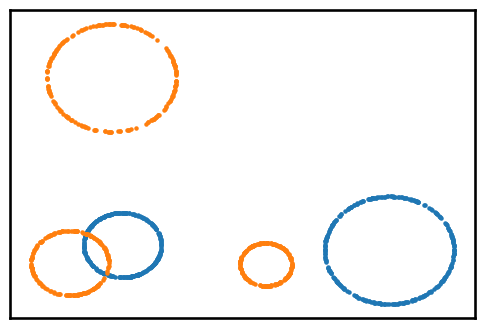

In [157]:
plt.scatter(data_train[600,:,0], data_train[600,:,1], s=3)
plt.scatter(data_train[728,:,0], data_train[728,:,1], s=3)
plt.xticks([])
plt.yticks([])

### Let's calculate density for choosen point clouds pairs with bootstrap.

In [158]:
with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_data.npy', 'wb') as f:
    np.save(f, data_train)
with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_label.npy', 'wb') as f:
    np.save(f, label_train)
with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_indexes.npy', 'wb') as f:
    np.save(f, train_indexes)

In [159]:
n_boostrap = 10
train_PD = []
for i,j in tqdm(train_indexes):  
    barc = [mtd.calc_cross_barcodes(data_train[i], data_train[j], batch_size1 = 300, batch_size2 = 500, is_plot = False, pdist_device = "cuda") for _ in range(n_boostrap)]
    train_PD.append(barc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [3:13:20<00:00,  3.87s/it]


In [161]:
import pickle
with open("RipsNet_exp/cross_pd_circles_3000_strat_boost_10_PD.txt", "wb") as fp:   #Pickling
    pickle.dump(train_PD, fp)

In [5]:
import pickle
with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_data.npy', 'rb') as f:
    data_train = np.load(f)
with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_label.npy', 'rb') as f:
    label_train = np.load(f)
with open('RipsNet_exp/cross_pd_circles_3000_strat_boost_10_indexes.npy', 'rb') as f:
    train_indexes = np.load(f)
with open("RipsNet_exp/cross_pd_circles_3000_strat_boost_10_PD.txt", 'rb') as fp:   #Pickling
    train_PD = pickle.load(fp)

In [6]:
# train_PD_1 = [x[1] if len(x[1])>0 else np.array([[0., 0.]]) for x in train_PD ]
train_PD_1 = [[x[1] if len(x[1])>0 else np.array([[0., 0.]]) for x in barcs ] for barcs in train_PD]

### Check how adequate these barcodes are

In [187]:
data_train.shape

(900, 600, 2)

In [188]:
indexes = train_indexes[np.random.choice(3000, 5, replace = False)]

  0%|                                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]

300
max0,976Barcode 0 = 0.62432575
maxBarcode 0 = 3.3877923
middleBarcode 0 = 0.1112576
4
max0,976Barcode 1 = 7.5387917
maxBarcode 1 = 7.5387917
middleBarcode 1 = 4.559446


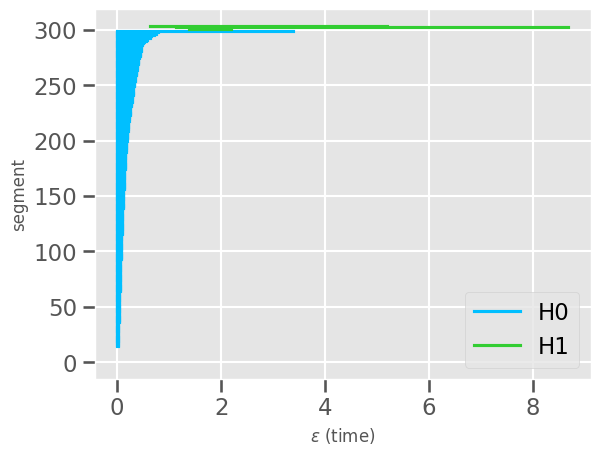

300
max0,976Barcode 0 = 0.6292983
maxBarcode 0 = 3.3877923
middleBarcode 0 = 0.10808862
5
max0,976Barcode 1 = 7.7115974
maxBarcode 1 = 7.7115974
middleBarcode 1 = 0.82316613


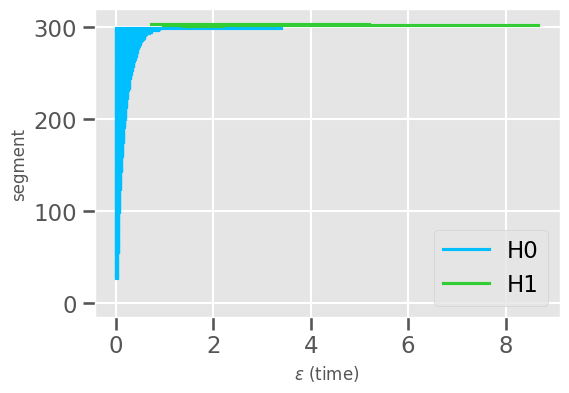

300
max0,976Barcode 0 = 0.62918174
maxBarcode 0 = 3.3877923
middleBarcode 0 = 0.12536447
7
max0,976Barcode 1 = 7.434915
maxBarcode 1 = 7.434915
middleBarcode 1 = 0.009629548


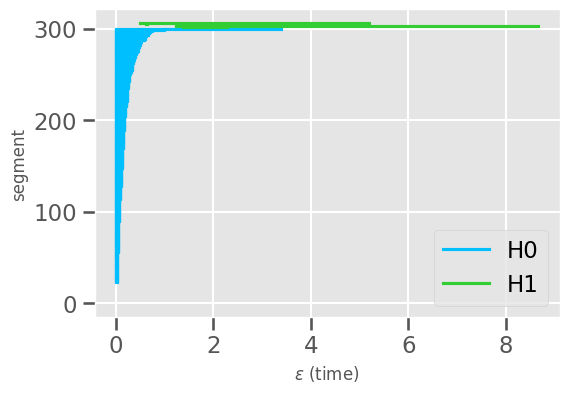

300
max0,976Barcode 0 = 0.5684972
maxBarcode 0 = 3.3921306
middleBarcode 0 = 0.10593083
6
max0,976Barcode 1 = 6.7568283
maxBarcode 1 = 6.7568283
middleBarcode 1 = 0.82180786


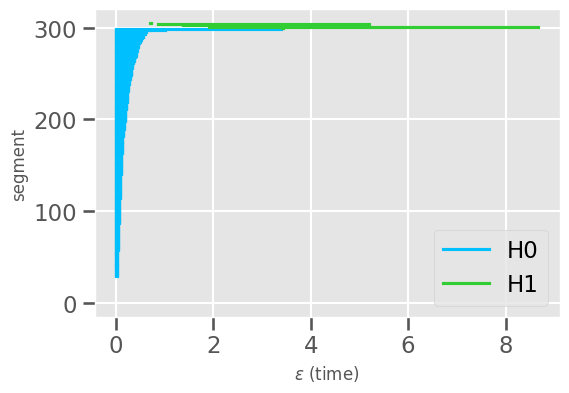

300
max0,976Barcode 0 = 0.62918174
maxBarcode 0 = 3.3877923
middleBarcode 0 = 0.10987278
6
max0,976Barcode 1 = 7.734005
maxBarcode 1 = 7.734005
middleBarcode 1 = 0.81186914


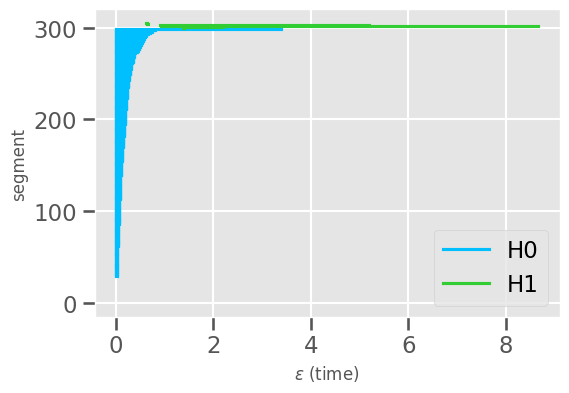

300
max0,976Barcode 0 = 0.6687099
maxBarcode 0 = 3.389573
middleBarcode 0 = 0.107306406
6
max0,976Barcode 1 = 7.5284786
maxBarcode 1 = 7.5284786
middleBarcode 1 = 0.90675354


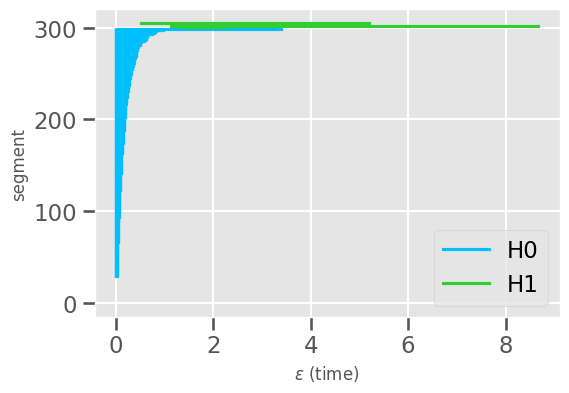

300
max0,976Barcode 0 = 0.62432575
maxBarcode 0 = 3.3877923
middleBarcode 0 = 0.119643286
6
max0,976Barcode 1 = 7.9196215
maxBarcode 1 = 7.9196215
middleBarcode 1 = 0.90675354


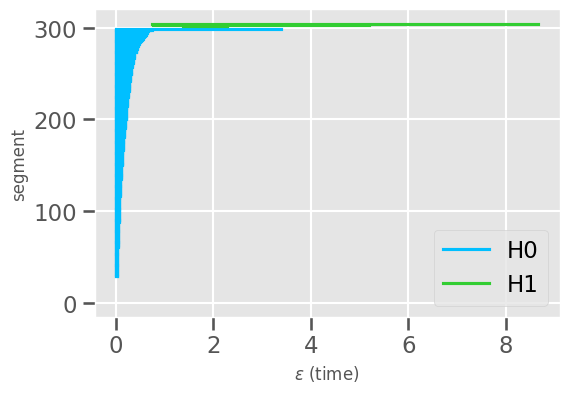

300
max0,976Barcode 0 = 0.6928271
maxBarcode 0 = 3.3877923
middleBarcode 0 = 0.11525729
5
max0,976Barcode 1 = 7.5334587
maxBarcode 1 = 7.5334587
middleBarcode 1 = 0.8130945


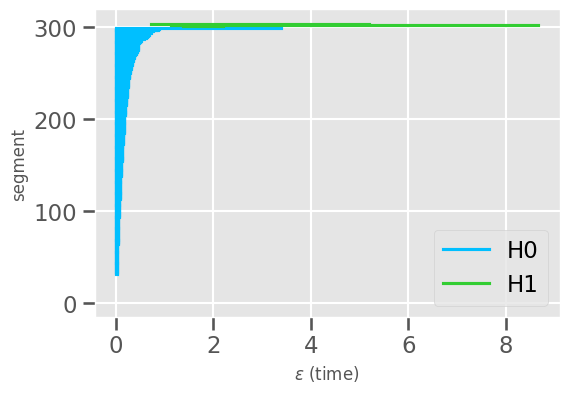

300
max0,976Barcode 0 = 0.6292983
maxBarcode 0 = 3.3877923
middleBarcode 0 = 0.1112576
5
max0,976Barcode 1 = 7.0127654
maxBarcode 1 = 7.0127654
middleBarcode 1 = 0.8989086


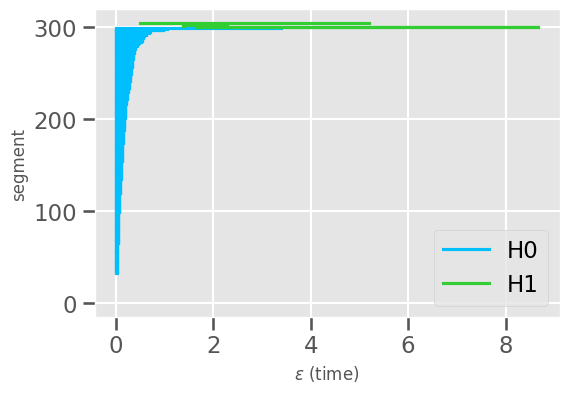

300
max0,976Barcode 0 = 0.632891
maxBarcode 0 = 3.3888032
middleBarcode 0 = 0.11631948
6
max0,976Barcode 1 = 7.576227
maxBarcode 1 = 7.576227
middleBarcode 1 = 0.90675354


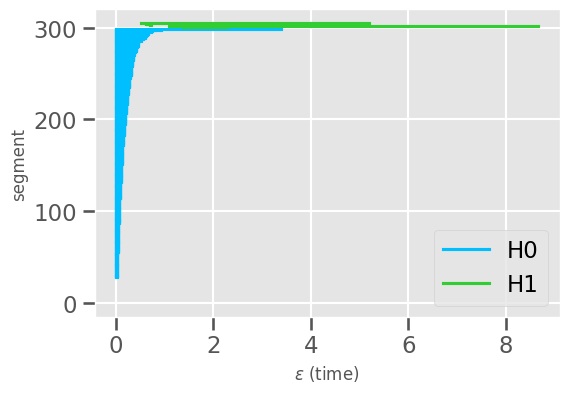

300
max0,976Barcode 0 = 0.6348653
maxBarcode 0 = 3.3877923
middleBarcode 0 = 0.10172545
5
max0,976Barcode 1 = 7.380479
maxBarcode 1 = 7.380479
middleBarcode 1 = 0.82180786


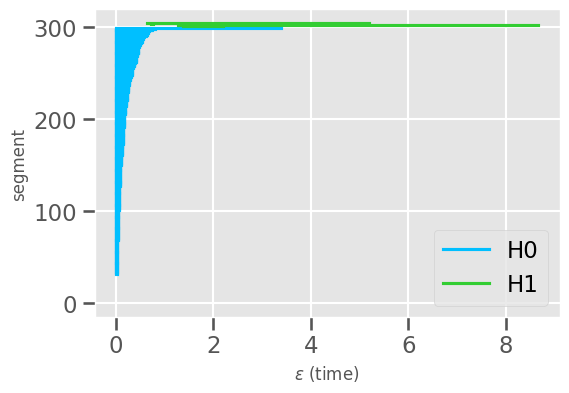

 20%|█████████████████████████████████▊                                                                                                                                       | 1/5 [00:17<01:11, 17.80s/it]

300
max0,976Barcode 0 = 0.1664839
maxBarcode 0 = 3.0352437
middleBarcode 0 = 0.030644862
1
max0,976Barcode 1 = 3.2503254
maxBarcode 1 = 3.2503254
middleBarcode 1 = 3.2503254


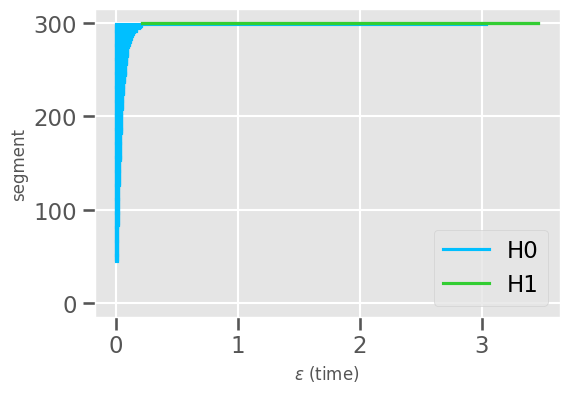

300
max0,976Barcode 0 = 0.16020477
maxBarcode 0 = 3.0352437
middleBarcode 0 = 0.029300876
1
max0,976Barcode 1 = 3.1354475
maxBarcode 1 = 3.1354475
middleBarcode 1 = 3.1354475


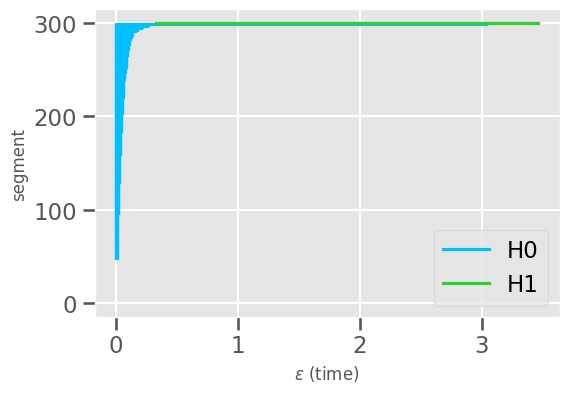

300
max0,976Barcode 0 = 0.17253542
maxBarcode 0 = 3.0353298
middleBarcode 0 = 0.03081166
1
max0,976Barcode 1 = 3.223077
maxBarcode 1 = 3.223077
middleBarcode 1 = 3.223077


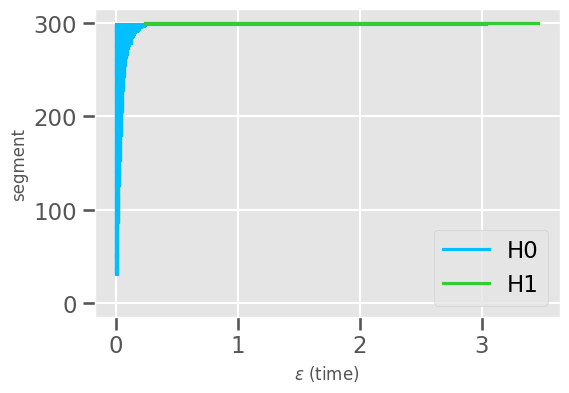

300
max0,976Barcode 0 = 0.1406983
maxBarcode 0 = 3.0352437
middleBarcode 0 = 0.031087533
1
max0,976Barcode 1 = 3.2117307
maxBarcode 1 = 3.2117307
middleBarcode 1 = 3.2117307


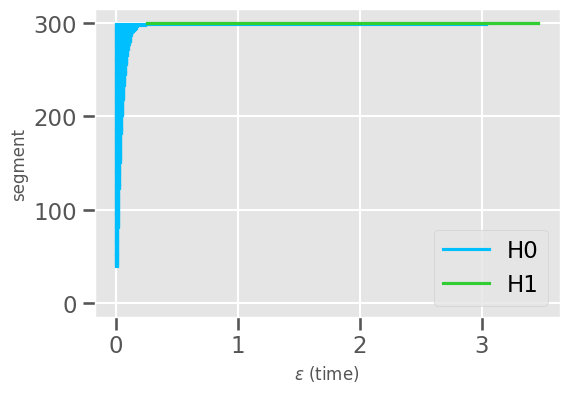

300
max0,976Barcode 0 = 0.15336238
maxBarcode 0 = 3.0371044
middleBarcode 0 = 0.029300876
1
max0,976Barcode 1 = 3.2340784
maxBarcode 1 = 3.2340784
middleBarcode 1 = 3.2340784


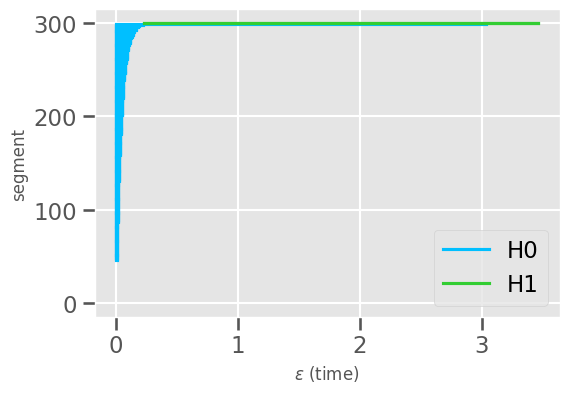

300
max0,976Barcode 0 = 0.15107141
maxBarcode 0 = 3.0358162
middleBarcode 0 = 0.029115854
1
max0,976Barcode 1 = 3.179391
maxBarcode 1 = 3.179391
middleBarcode 1 = 3.179391


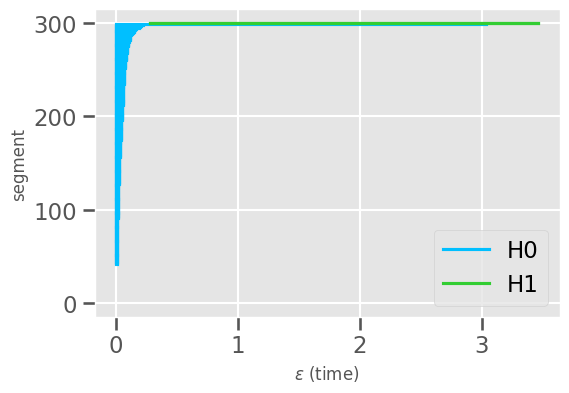

300
max0,976Barcode 0 = 0.14322741
maxBarcode 0 = 3.0353298
middleBarcode 0 = 0.03189337
1
max0,976Barcode 1 = 3.273461
maxBarcode 1 = 3.273461
middleBarcode 1 = 3.273461


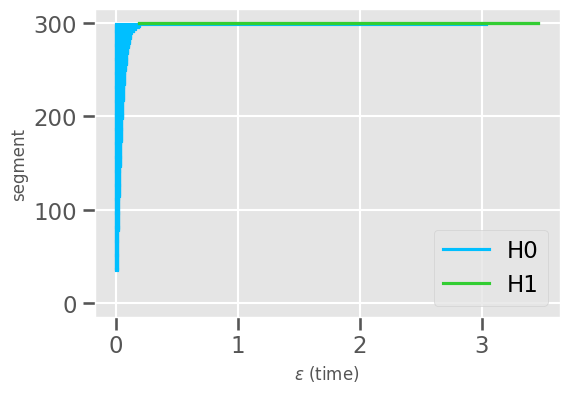

300
max0,976Barcode 0 = 0.14658172
maxBarcode 0 = 3.0353298
middleBarcode 0 = 0.03331578
1
max0,976Barcode 1 = 3.1916394
maxBarcode 1 = 3.1916394
middleBarcode 1 = 3.1916394


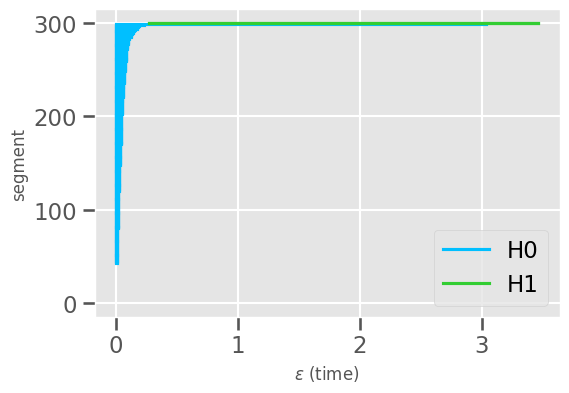

300
max0,976Barcode 0 = 0.14225078
maxBarcode 0 = 3.0353298
middleBarcode 0 = 0.02739255
1
max0,976Barcode 1 = 3.2046607
maxBarcode 1 = 3.2046607
middleBarcode 1 = 3.2046607


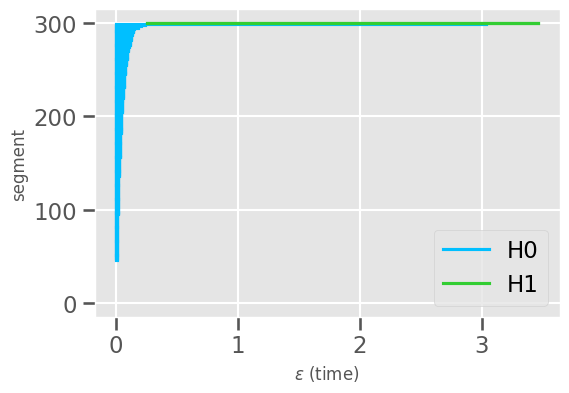

300
max0,976Barcode 0 = 0.1664839
maxBarcode 0 = 3.0352437
middleBarcode 0 = 0.028324863
1
max0,976Barcode 1 = 3.0871775
maxBarcode 1 = 3.0871775
middleBarcode 1 = 3.0871775


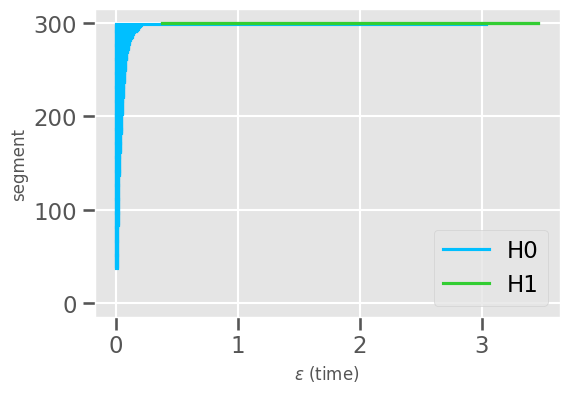

300
max0,976Barcode 0 = 0.16636764
maxBarcode 0 = 3.0352454
middleBarcode 0 = 0.031031799
1
max0,976Barcode 1 = 3.2077062
maxBarcode 1 = 3.2077062
middleBarcode 1 = 3.2077062


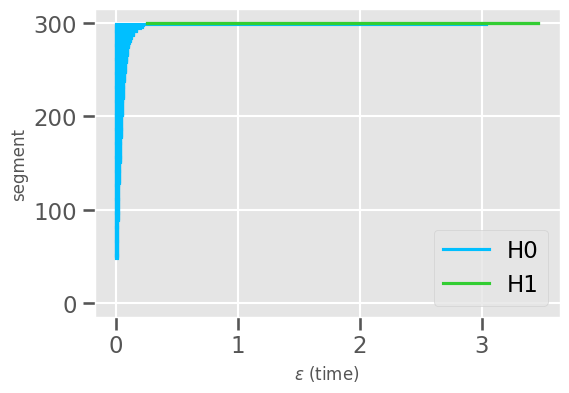

 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 2/5 [00:35<00:53, 17.96s/it]

300
max0,976Barcode 0 = 0.59137017
maxBarcode 0 = 0.78723025
middleBarcode 0 = 0.100083694
12
max0,976Barcode 1 = 2.9701293
maxBarcode 1 = 2.9701293
middleBarcode 1 = 0.039806888


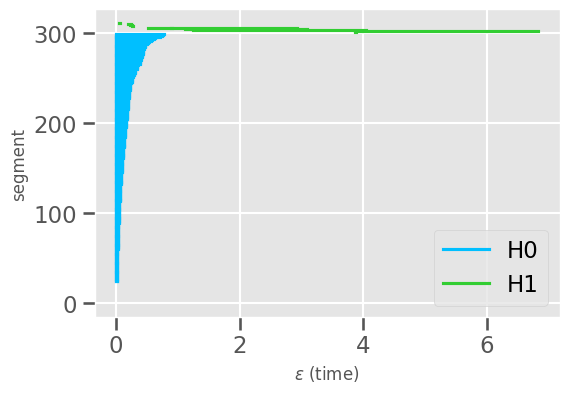

300
max0,976Barcode 0 = 0.5868527
maxBarcode 0 = 1.132632
middleBarcode 0 = 0.10563997
13
max0,976Barcode 1 = 2.9714735
maxBarcode 1 = 2.9714735
middleBarcode 1 = 0.0144715905


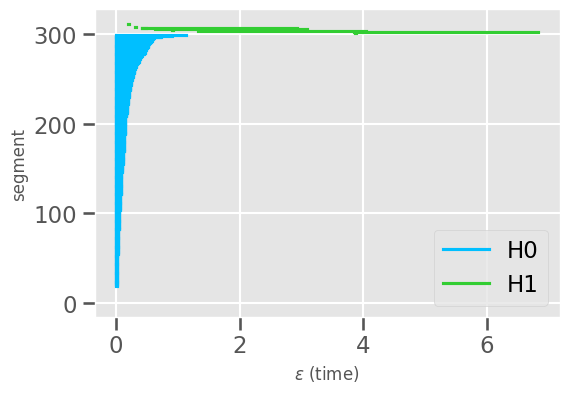

300
max0,976Barcode 0 = 0.6103596
maxBarcode 0 = 0.97143847
middleBarcode 0 = 0.0932247
12
max0,976Barcode 1 = 2.9790583
maxBarcode 1 = 2.9790583
middleBarcode 1 = 0.008362502


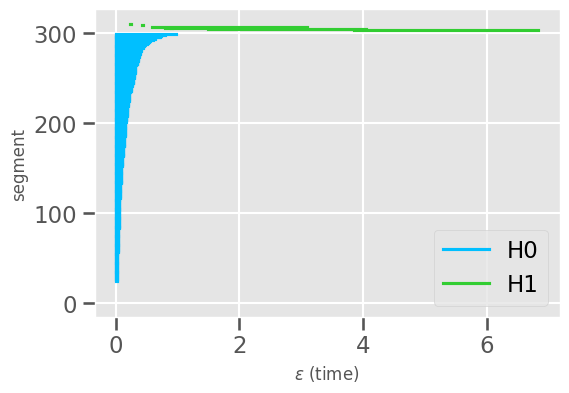

300
max0,976Barcode 0 = 0.5589175
maxBarcode 0 = 1.1873188
middleBarcode 0 = 0.107884474
13
max0,976Barcode 1 = 2.9722636
maxBarcode 1 = 2.9722636
middleBarcode 1 = 0.054641187


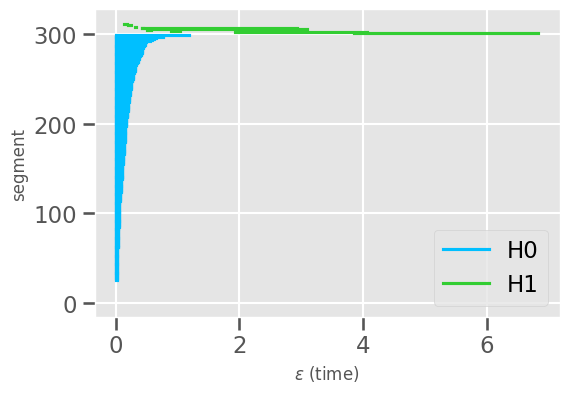

300
max0,976Barcode 0 = 0.5617242
maxBarcode 0 = 1.0801444
middleBarcode 0 = 0.10295709
14
max0,976Barcode 1 = 2.9751267
maxBarcode 1 = 2.9751267
middleBarcode 1 = 0.048437804


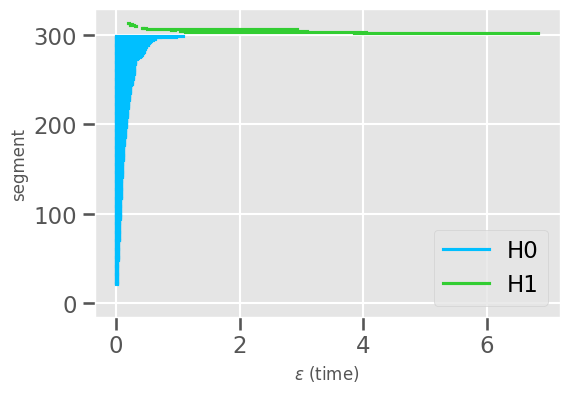

300
max0,976Barcode 0 = 0.5947713
maxBarcode 0 = 0.7641824
middleBarcode 0 = 0.10480522
15
max0,976Barcode 1 = 2.970556
maxBarcode 1 = 2.970556
middleBarcode 1 = 0.010597378


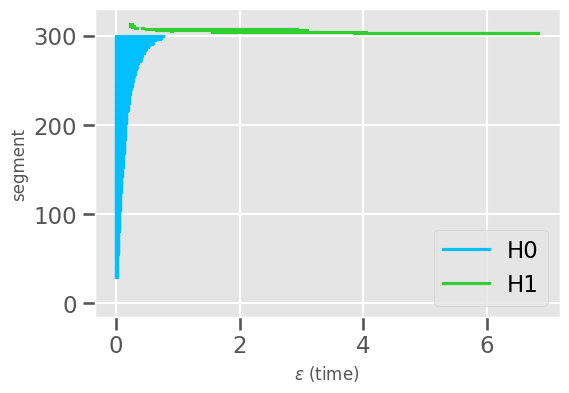

300
max0,976Barcode 0 = 0.5617242
maxBarcode 0 = 1.0424665
middleBarcode 0 = 0.087508924
13
max0,976Barcode 1 = 2.9604106
maxBarcode 1 = 2.9604106
middleBarcode 1 = 0.06017384


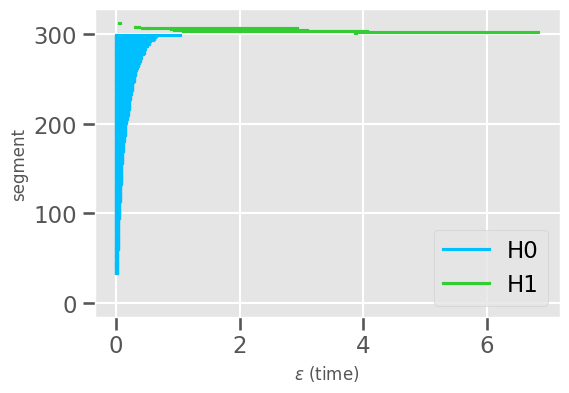

300
max0,976Barcode 0 = 0.5325214
maxBarcode 0 = 0.80548555
middleBarcode 0 = 0.11080931
12
max0,976Barcode 1 = 3.2339082
maxBarcode 1 = 3.2339082
middleBarcode 1 = 0.01513499


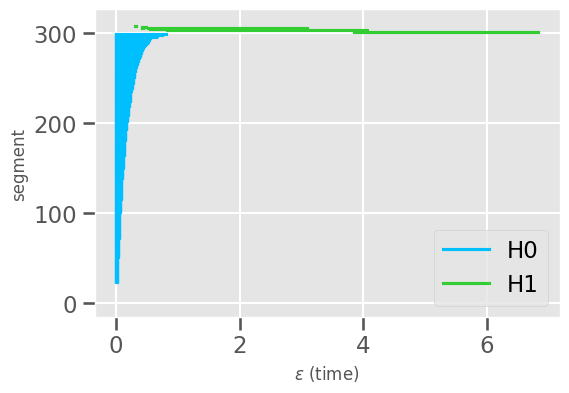

300
max0,976Barcode 0 = 0.619897
maxBarcode 0 = 0.9731634
middleBarcode 0 = 0.09444804
20
max0,976Barcode 1 = 2.9752345
maxBarcode 1 = 2.9752345
middleBarcode 1 = 0.010597378


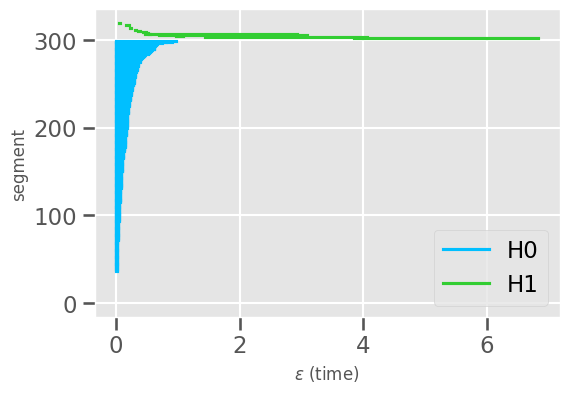

300
max0,976Barcode 0 = 0.58161974
maxBarcode 0 = 0.8445682
middleBarcode 0 = 0.1123259
15
max0,976Barcode 1 = 2.9713657
maxBarcode 1 = 2.9713657
middleBarcode 1 = 0.01513499


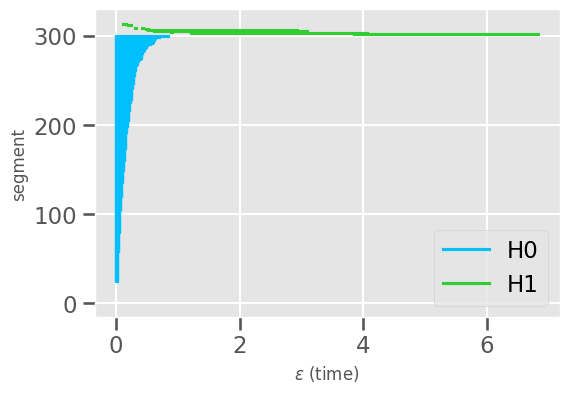

300
max0,976Barcode 0 = 0.5589175
maxBarcode 0 = 0.73190993
middleBarcode 0 = 0.09327871
12
max0,976Barcode 1 = 2.9685993
maxBarcode 1 = 2.9685993
middleBarcode 1 = 0.01513499


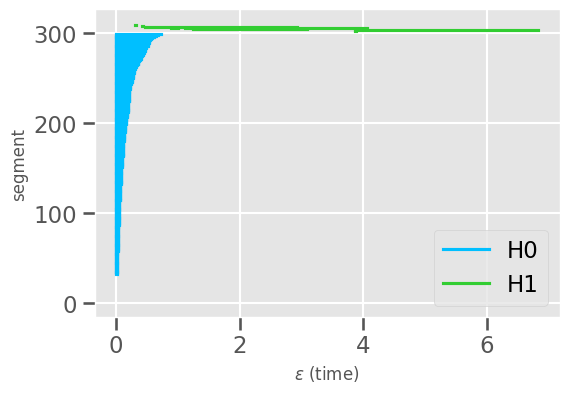

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 3/5 [00:53<00:35, 17.62s/it]

300
max0,976Barcode 0 = 0.14904568
maxBarcode 0 = 4.869125
middleBarcode 0 = 0.030548584
1
max0,976Barcode 1 = 3.178427
maxBarcode 1 = 3.178427
middleBarcode 1 = 3.178427


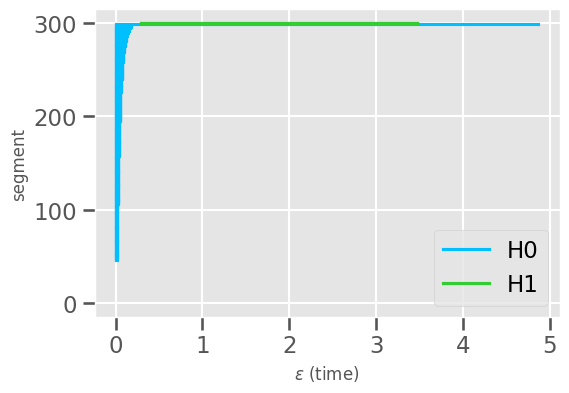

300
max0,976Barcode 0 = 0.14522634
maxBarcode 0 = 4.869125
middleBarcode 0 = 0.031202855
1
max0,976Barcode 1 = 3.2246575
maxBarcode 1 = 3.2246575
middleBarcode 1 = 3.2246575


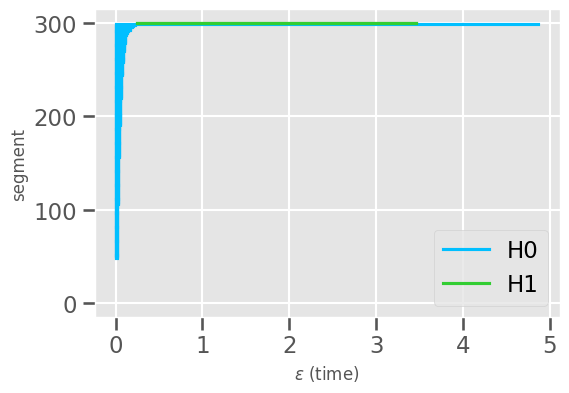

300
max0,976Barcode 0 = 0.14291248
maxBarcode 0 = 4.868887
middleBarcode 0 = 0.030351102
1
max0,976Barcode 1 = 3.132848
maxBarcode 1 = 3.132848
middleBarcode 1 = 3.132848


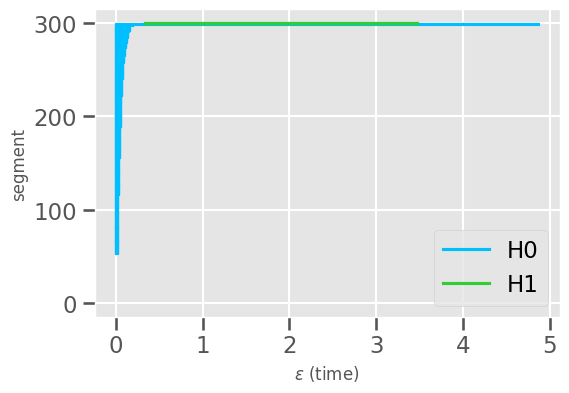

300
max0,976Barcode 0 = 0.15214737
maxBarcode 0 = 4.868887
middleBarcode 0 = 0.0297784
1
max0,976Barcode 1 = 3.237
maxBarcode 1 = 3.237
middleBarcode 1 = 3.237


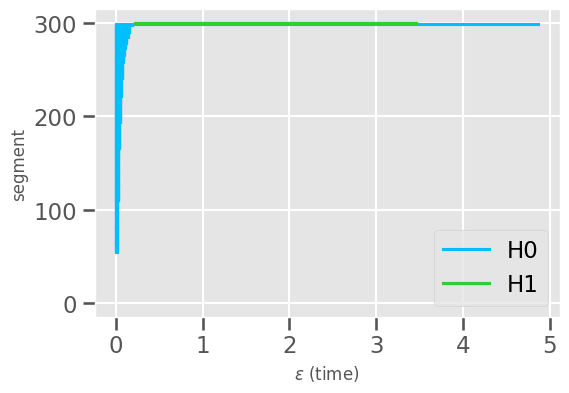

300
max0,976Barcode 0 = 0.16366108
maxBarcode 0 = 4.872834
middleBarcode 0 = 0.02818816
1
max0,976Barcode 1 = 3.158813
maxBarcode 1 = 3.158813
middleBarcode 1 = 3.158813


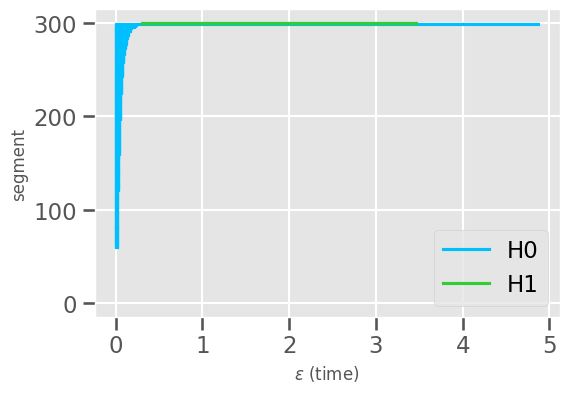

300
max0,976Barcode 0 = 0.1582711
maxBarcode 0 = 4.872853
middleBarcode 0 = 0.032271303
1
max0,976Barcode 1 = 3.2202573
maxBarcode 1 = 3.2202573
middleBarcode 1 = 3.2202573


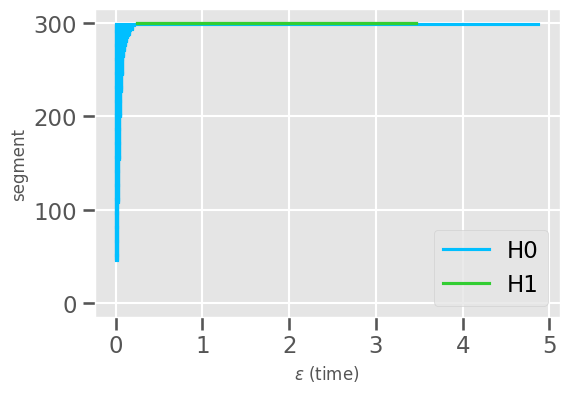

300
max0,976Barcode 0 = 0.1599755
maxBarcode 0 = 4.8688917
middleBarcode 0 = 0.03119086
1
max0,976Barcode 1 = 3.1999185
maxBarcode 1 = 3.1999185
middleBarcode 1 = 3.1999185


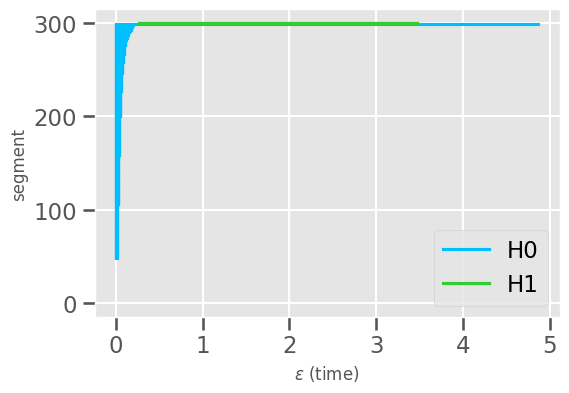

300
max0,976Barcode 0 = 0.15716273
maxBarcode 0 = 4.868887
middleBarcode 0 = 0.03149136
1
max0,976Barcode 1 = 3.0745137
maxBarcode 1 = 3.0745137
middleBarcode 1 = 3.0745137


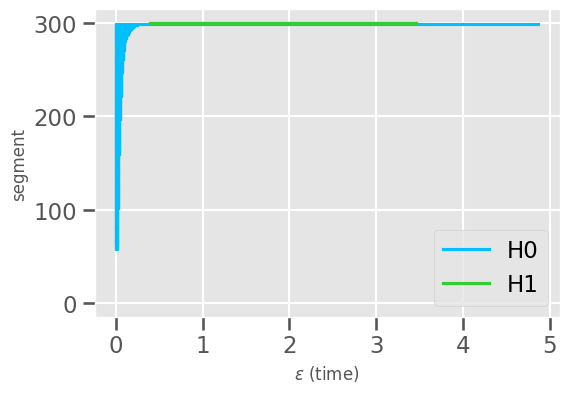

300
max0,976Barcode 0 = 0.16009472
maxBarcode 0 = 4.8728256
middleBarcode 0 = 0.03158859
1
max0,976Barcode 1 = 3.231535
maxBarcode 1 = 3.231535
middleBarcode 1 = 3.231535


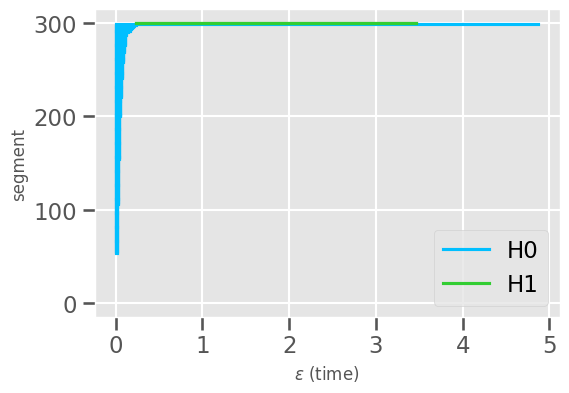

300
max0,976Barcode 0 = 0.14467764
maxBarcode 0 = 4.8688917
middleBarcode 0 = 0.031202855
1
max0,976Barcode 1 = 3.2254386
maxBarcode 1 = 3.2254386
middleBarcode 1 = 3.2254386


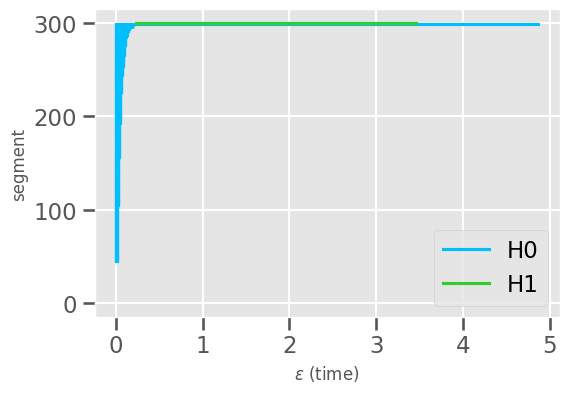

300
max0,976Barcode 0 = 0.18364096
maxBarcode 0 = 4.868887
middleBarcode 0 = 0.029505482
1
max0,976Barcode 1 = 3.1138842
maxBarcode 1 = 3.1138842
middleBarcode 1 = 3.1138842


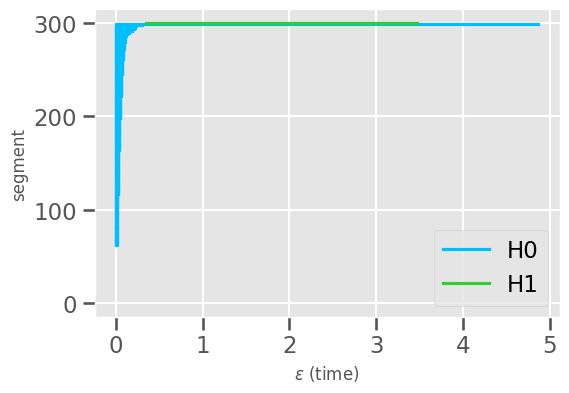

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 4/5 [01:10<00:17, 17.49s/it]

300
max0,976Barcode 0 = 0.13590686
maxBarcode 0 = 6.6451483
middleBarcode 0 = 0.03072787
2
max0,976Barcode 1 = 3.183847
maxBarcode 1 = 3.183847
middleBarcode 1 = 3.183847


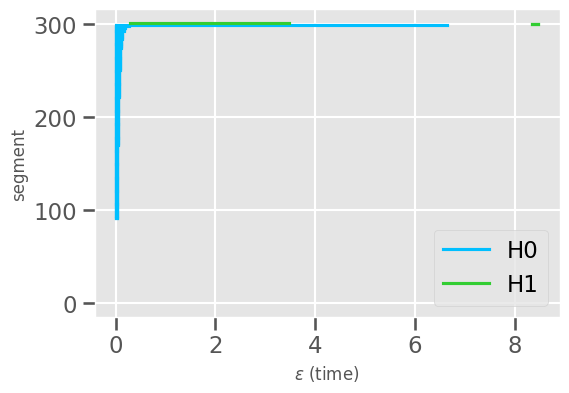

298
max0,976Barcode 0 = 0.12592828
maxBarcode 0 = 6.645152
middleBarcode 0 = 0.034754608
2
max0,976Barcode 1 = 3.1745996
maxBarcode 1 = 3.1745996
middleBarcode 1 = 3.1745996


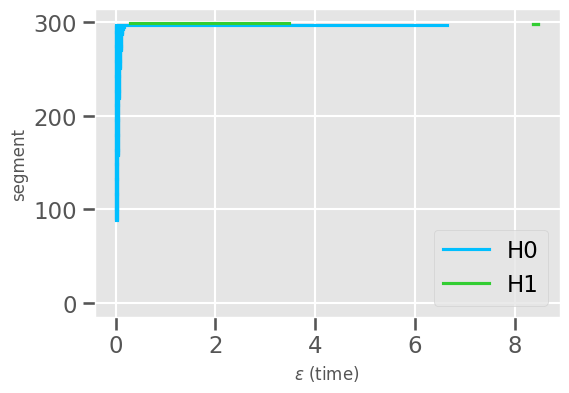

300
max0,976Barcode 0 = 0.15240023
maxBarcode 0 = 6.6451483
middleBarcode 0 = 0.03115503
2
max0,976Barcode 1 = 3.245537
maxBarcode 1 = 3.245537
middleBarcode 1 = 3.245537


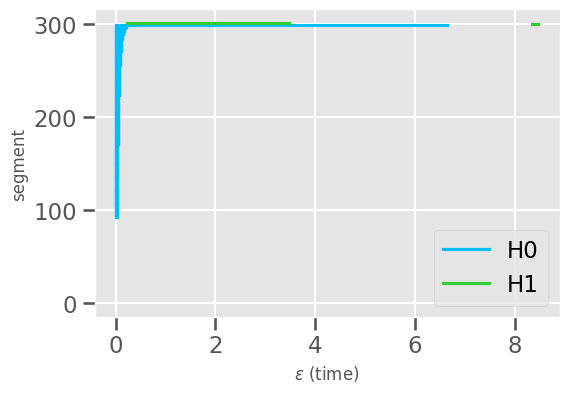

300
max0,976Barcode 0 = 0.15328002
maxBarcode 0 = 6.6451483
middleBarcode 0 = 0.032315183
2
max0,976Barcode 1 = 3.2291868
maxBarcode 1 = 3.2291868
middleBarcode 1 = 3.2291868


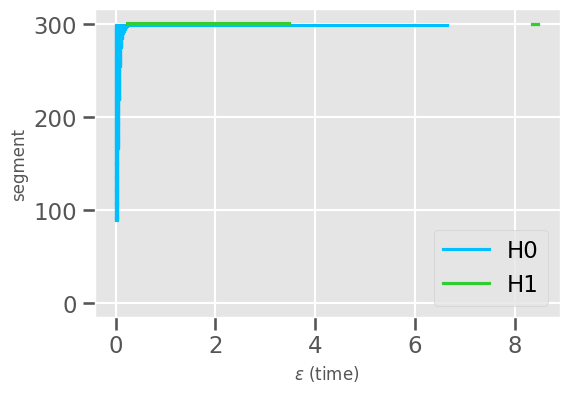

299
max0,976Barcode 0 = 0.14924507
maxBarcode 0 = 6.645152
middleBarcode 0 = 0.031018846
2
max0,976Barcode 1 = 3.1280053
maxBarcode 1 = 3.1280053
middleBarcode 1 = 3.1280053


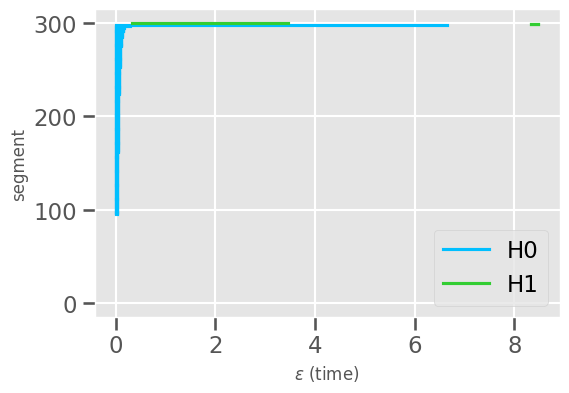

299
max0,976Barcode 0 = 0.15702733
maxBarcode 0 = 6.645152
middleBarcode 0 = 0.032765854
2
max0,976Barcode 1 = 3.265563
maxBarcode 1 = 3.265563
middleBarcode 1 = 3.265563


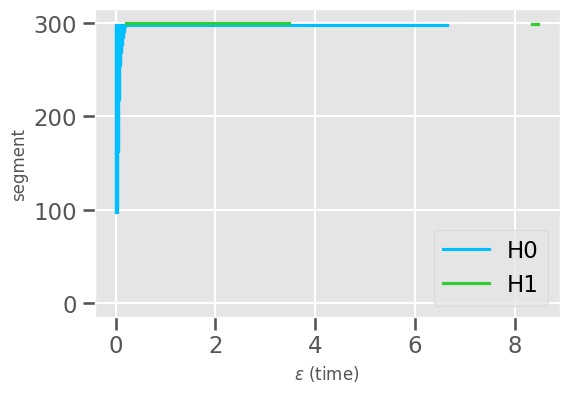

300
max0,976Barcode 0 = 0.14935492
maxBarcode 0 = 6.6451483
middleBarcode 0 = 0.029608414
2
max0,976Barcode 1 = 3.2654302
maxBarcode 1 = 3.2654302
middleBarcode 1 = 3.2654302


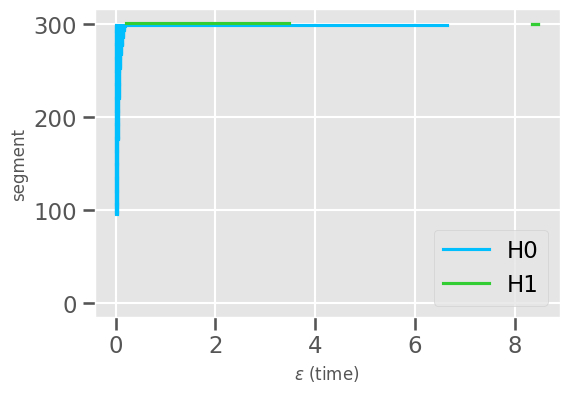

300
max0,976Barcode 0 = 0.16180028
maxBarcode 0 = 6.6451483
middleBarcode 0 = 0.029816957
2
max0,976Barcode 1 = 3.2251825
maxBarcode 1 = 3.2251825
middleBarcode 1 = 3.2251825


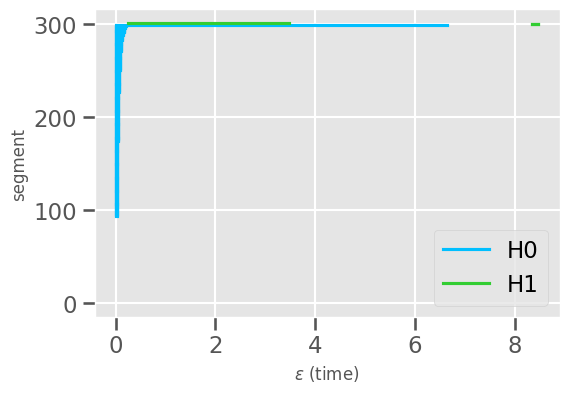

299
max0,976Barcode 0 = 0.17014772
maxBarcode 0 = 6.645375
middleBarcode 0 = 0.03170454
2
max0,976Barcode 1 = 3.240686
maxBarcode 1 = 3.240686
middleBarcode 1 = 3.240686


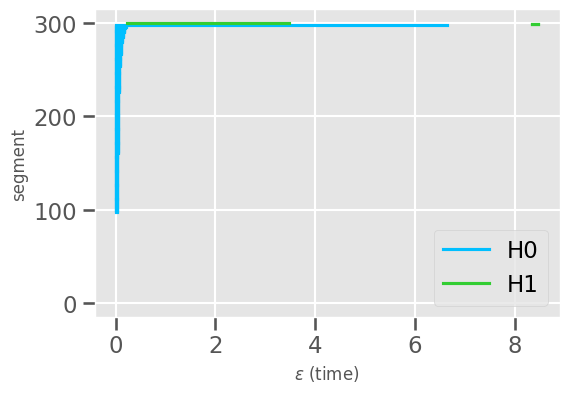

300
max0,976Barcode 0 = 0.17020163
maxBarcode 0 = 6.6453633
middleBarcode 0 = 0.030934537
2
max0,976Barcode 1 = 3.204212
maxBarcode 1 = 3.204212
middleBarcode 1 = 3.204212


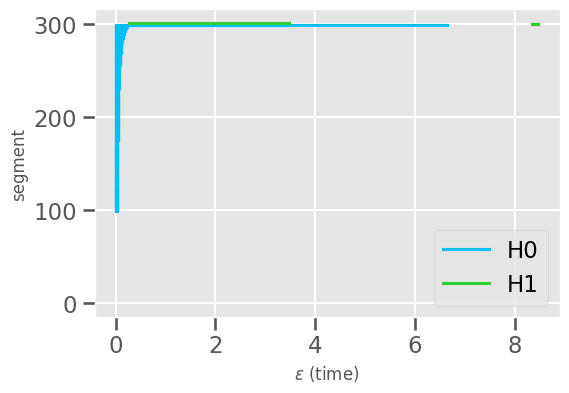

300
max0,976Barcode 0 = 0.16346425
maxBarcode 0 = 6.6451483
middleBarcode 0 = 0.029590325
2
max0,976Barcode 1 = 3.1822028
maxBarcode 1 = 3.1822028
middleBarcode 1 = 3.1822028


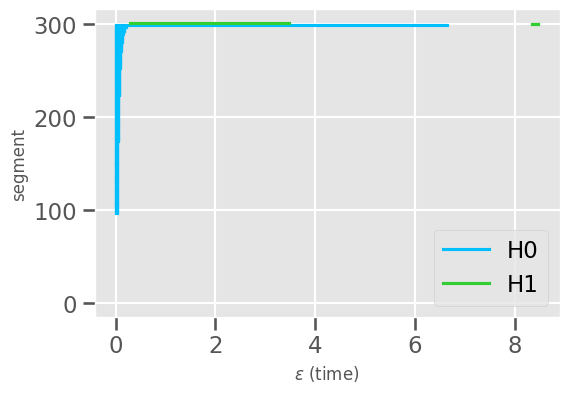

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:27<00:00, 17.58s/it]


In [222]:
n_boostrap = 11
barcs_5 = []
for ids in tqdm(indexes):
    # print(ids)
    barc = [mtd.calc_cross_barcodes(data_train[ids[0]], data_train[ids[1]], batch_size1 = 300, batch_size2 = 500, is_plot = True, pdist_device = "cpu") for _ in range(n_boostrap)]
    barcs_5.append(barc)

In [191]:
barcs_5 = [[v[1] for v in smth] for smth in barcs_5]

In [210]:
barcs_5[0]

[array([[1.6637616 , 8.664422  ],
        [1.3871638 , 1.4015675 ],
        [1.382531  , 2.197057  ],
        [0.72272015, 0.72291315],
        [0.6512457 , 0.6537288 ],
        [0.64406455, 5.201098  ],
        [0.632019  , 0.63676107]], dtype=float32),
 array([[1.4510671 , 1.501587  ],
        [1.4039679 , 2.2378469 ],
        [1.2966036 , 8.670683  ],
        [0.9099654 , 5.198888  ],
        [0.6292983 , 0.63676107]], dtype=float32),
 array([[1.485743 , 8.67233  ],
        [1.3871638, 1.3880837],
        [1.3752491, 2.218953 ],
        [0.6472278, 0.6604049],
        [0.6354797, 0.6355   ],
        [0.5961548, 5.1966023]], dtype=float32),
 array([[3.425145  , 3.4623146 ],
        [1.3935552 , 1.3958087 ],
        [1.3752491 , 1.3779277 ],
        [1.3748    , 2.2806444 ],
        [1.1011714 , 8.665694  ],
        [0.7161005 , 5.2006555 ],
        [0.69762534, 0.70224684],
        [0.6354797 , 0.64942986]], dtype=float32),
 array([[1.9368358, 8.663699 ],
        [1.4702066, 1.474919

In [200]:
pds_train = DiagramSelector(use=True).fit_transform(barcs_5[0])
vpdtr = np.vstack(pds_train)

for barcs in barcs_5[1:]:
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    vpdtr = np.vstack((vpdtr, np.vstack(pds_train)))

pers = vpdtr[:,1]-vpdtr[:,0]
bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
# sigma = np.quantile(ppers, .2) ## доделать
im_bnds = [np.quantile(vpdtr[:,0],0.001), np.quantile(vpdtr[:,0],0.9), np.quantile(pers,0.2), np.quantile(pers,0.999)]

In [201]:
im_bnds

[0.059331174939870834,
 4.048068523406982,
 0.0046215057373046875,
 7.753057479858398]

In [215]:
from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances
from gudhi.representations import  PersistenceImage

PI_5_all = []
for barcs in barcs_5:
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    # clean_pds_test = DiagramSelector(use=True).fit_transform(train_PD_1[800:])
    
    
    vpdtr = np.vstack(pds_train)
    pers = vpdtr[:,1]-vpdtr[:,0]
    # bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
    # ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
    sigma = np.quantile(ppers, .2)
    # im_bnds = [np.quantile(vpdtr[:,0],0.2), np.quantile(vpdtr[:,0],0.8), np.quantile(pers,0.2), np.quantile(pers,0.8)]
    # # im_bnds = [0, 1, 0, np.quantile(pers,1.)]
    # # sp_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,1],1.)]
    
    
    PI_params = {'bandwidth': sigma, 'weight': lambda x: x[1], 
                 'resolution': [50,50], 'im_range': im_bnds}
    PI_5 = PersistenceImage(**PI_params).fit_transform(pds_train)
    # clean_PI_test = PersistenceImage(**PI_params).fit_transform(clean_pds_test)
    PI_5 = np.sum(PI_5,axis = 0)/n_boostrap
    PI_5 = PI_5/np.sum(PI_5)
    PI_5_all.append(PI_5)
    
PI_5_all = np.array(PI_5_all)

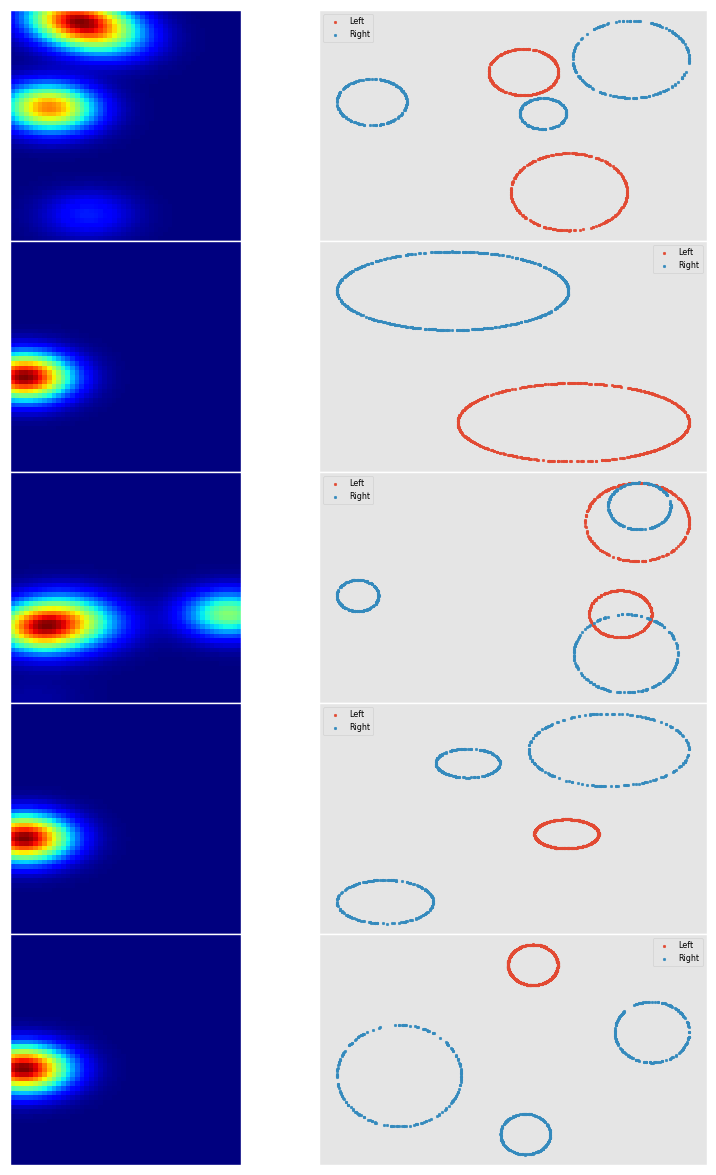

In [216]:
fig = plt.figure(figsize=(10, 15)) 
gs = gridspec.GridSpec(5, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)

for i in range(5):
    ax = plt.subplot(gs[i, 0])
    ax.imshow(np.flip(np.reshape(PI_5_all[i], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[i, 1])
    ax.scatter(data_train[indexes[i][0],:, 0], data_train[indexes[i][0],:, 1], s=3,label = "Left")
    ax.scatter(data_train[indexes[i][1],:, 0], data_train[indexes[i][1],:, 1], s=3,label = "Right")
    plt.xticks([])
    plt.yticks([])
    plt.legend(fontsize = "xx-small")

---

### Base transformation y-axis to persistence is made automatically inside **gudhi.representations.PersistenceImage**

In [7]:
pds_train = DiagramSelector(use=True).fit_transform(train_PD_1[0])
vpdtr = np.vstack(pds_train)

for barcs in train_PD_1[1:]:
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    vpdtr = np.vstack((vpdtr, np.vstack(pds_train)))

pers = vpdtr[:,1]-vpdtr[:,0]
bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
sigma = np.quantile(ppers, .2) ## доделать
im_bnds = [np.quantile(vpdtr[:,0],0.001), np.quantile(vpdtr[:,0],0.9), np.quantile(pers,0.2), np.quantile(pers,0.999)]

In [8]:
# for barcs in train_PD_1:
#     for barc in barcs:
#         barc[:, 1] = barc[:, 1]- barc[:, 0]

In [9]:
from gudhi.representations import DiagramSelector
from sklearn.metrics import pairwise_distances
from gudhi.representations import  PersistenceImage

PI_train_all = []
for barcs in tqdm(train_PD_1):
    pds_train = DiagramSelector(use=True).fit_transform(barcs)
    # clean_pds_test = DiagramSelector(use=True).fit_transform(train_PD_1[800:])
    
    
    vpdtr = np.vstack(pds_train)
    pers = vpdtr[:,1]-vpdtr[:,0]
    # bps_pairs = pairwise_distances(np.hstack([vpdtr[:,0:1],vpdtr[:,1:2]-vpdtr[:,0:1]])[:200]).flatten()
    # ppers = bps_pairs[np.argwhere(bps_pairs > 1e-5).ravel()]
    sigma = np.quantile(ppers, .2)
    # im_bnds = [np.quantile(vpdtr[:,0],0.2), np.quantile(vpdtr[:,0],0.8), np.quantile(pers,0.2), np.quantile(pers,0.8)]
    # # im_bnds = [0, 1, 0, np.quantile(pers,1.)]
    # # sp_bnds = [np.quantile(vpdtr[:,0],0.), np.quantile(vpdtr[:,1],1.)]
    
    
    PI_params = {'bandwidth': sigma, 'weight': lambda x: x[1]**3, 
                 'resolution': [50,50], 'im_range': im_bnds}
    PI_train = PersistenceImage(**PI_params).fit_transform(pds_train)
    # clean_PI_test = PersistenceImage(**PI_params).fit_transform(clean_pds_test)
    PI_train = np.sum(PI_train,axis = 0)/n_boostrap
    PI_train = PI_train/np.sum(PI_train)
    PI_train_all.append(PI_train)
    
PI_train_all = np.array(PI_train_all)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:17<00:00, 167.50it/s]


In [10]:
PI_train = np.vstack([PI_train_all[:800], PI_train_all[1000:1800], PI_train_all[2000:2800]])
clean_PI_test = np.vstack([PI_train_all[800:1000], PI_train_all[1800:2000], PI_train_all[2800:3000]])

In [11]:
train_PD_1[300*0+3][0]

array([[0.3136532, 3.4654038]], dtype=float32)

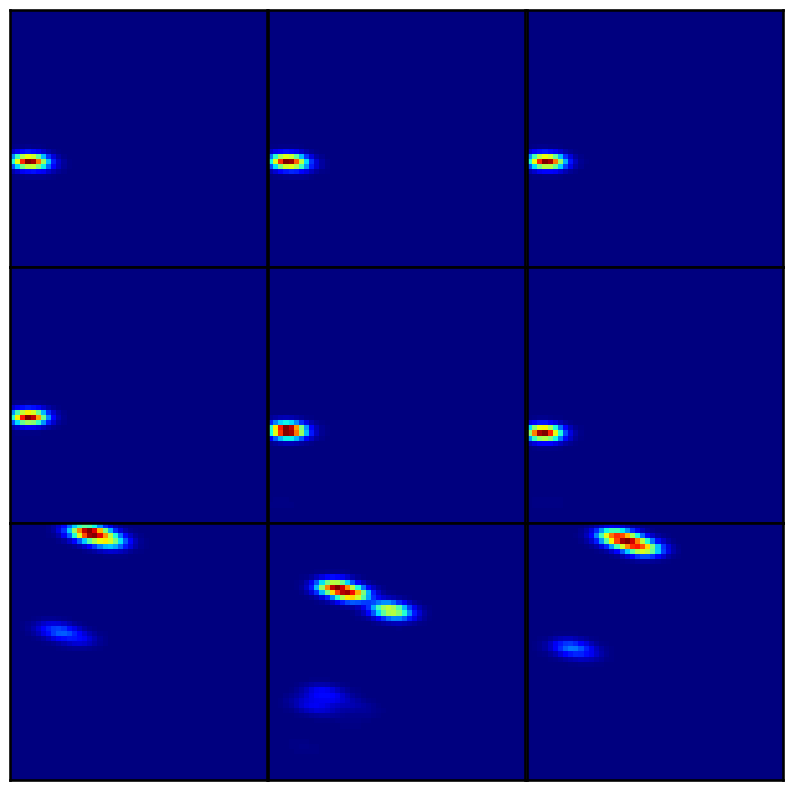

In [12]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(PI_train[1000*i+35*j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])

### First approach: just consider two point clouds as one big and preprocess them simultaneously

In [13]:
data_train_concat = np.array([np.vstack((data_train[i],data_train[j])) for i,j in np.vstack([train_indexes[:800], train_indexes[1000:1800], train_indexes[2000:2800]])])
data_test_concat = np.array([np.vstack((data_train[i],data_train[j])) for i,j in np.vstack([train_indexes[800:1000], train_indexes[1800:2000], train_indexes[2800:3000]])])

In [14]:
tf_data_train = tf.ragged.constant([
    [list(c) for c in list(data_train_concat[i])] for i in range(len(data_train_concat))], ragged_rank=1)
tf_data_test = tf.ragged.constant([
    [list(c) for c in list(data_test_concat[i])] for i in range(len(data_test_concat))], ragged_rank=1)
# tf_noisy_data_test = tf.ragged.constant([
#     [list(c) for c in list(noisy_data_test[i])] for i in range(len(noisy_data_test))], ragged_rank=1)

2024-08-28 15:15:06.228259: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 15:15:07.399706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10464 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


```python
find / -name 'libcudart.so.11.0'

# edit /etc/profile
sudo vim /etc/profile
# append path to "LD_LIBRARY_PATH" in profile file
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:usr/local/cuda-11.7/targets/x86_64-linux/lib/libcudart.so.11.0
# make environment file work
source /etc/profile
```

### Model

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                            patience=200, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=False)
optim = tf.keras.optimizers.Adamax(learning_rate=5e-4)
inputs = tf.keras.Input(shape=(None,2), dtype ="float32", ragged=True)
x = DenseRagged(units=40, use_bias=True, activation='relu')(inputs)
x = DenseRagged(units=30, use_bias=True, activation='relu')(x)
x = DenseRagged(units=15, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)
x = tf.keras.layers.Dense(50,  activation='relu')(x)
x = tf.keras.layers.Dense(100, activation='relu')(x)
x = tf.keras.layers.Dense(200, activation='relu')(x)
outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(x)
outputs = tf.keras.layers.Lambda(lambda x: tf.experimental.numpy.clip(x, 1e-8, None))(outputs) ## for preventiong calculating log(0)
outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)

model_PI = tf.keras.Model(inputs=inputs, outputs=outputs)
model_PI.compile(optimizer=optim, loss="kl_divergence")

In [218]:
model_PI.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 2)]         0         
                                                                 
 dense_ragged_3 (DenseRagged  (None, None, 40)         120       
 )                                                               
                                                                 
 dense_ragged_4 (DenseRagged  (None, None, 30)         1230      
 )                                                               
                                                                 
 dense_ragged_5 (DenseRagged  (None, None, 15)         465       
 )                                                               
                                                                 
 permop_ragged_1 (PermopRagg  (None, 15)               0         
 ed)                                                         

There we can try KL loss for better understanding

In [17]:
history = model_PI.fit(tf_data_train, PI_train, epochs=1000, 
                       validation_data=(tf_data_test, clean_PI_test), callbacks=[callback], verbose=1)

Epoch 1/1000
75/75 [==============================] - 2s 13ms/step - loss: 6.4971 - val_loss: 6.3536
Epoch 2/1000
75/75 [==============================] - 1s 8ms/step - loss: 6.3527 - val_loss: 6.3394
Epoch 3/1000
75/75 [==============================] - 1s 8ms/step - loss: 6.3400 - val_loss: 6.3312
Epoch 4/1000
75/75 [==============================] - 1s 8ms/step - loss: 6.3315 - val_loss: 6.3263
Epoch 5/1000
75/75 [==============================] - 1s 8ms/step - loss: 6.3270 - val_loss: 6.3208
Epoch 6/1000
75/75 [==============================] - 1s 8ms/step - loss: 6.3226 - val_loss: 6.3169
Epoch 7/1000
75/75 [==============================] - 1s 7ms/step - loss: 6.3194 - val_loss: 6.3128
Epoch 8/1000
75/75 [==============================] - 1s 8ms/step - loss: 6.3137 - val_loss: 6.3043
Epoch 9/1000
75/75 [==============================] - 1s 8ms/step - loss: 6.3035 - val_loss: 6.2940
Epoch 10/1000
75/75 [==============================] - 1s 8ms/step - loss: 6.2947 - val_loss: 6.287

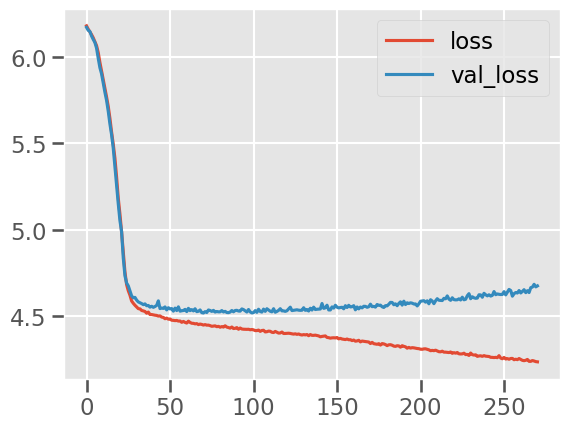

In [24]:
plt.plot(np.array(history.history["loss"][20:]))
plt.plot(np.array(history.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.show()

In [159]:
train_PI_prediction = model_PI.predict(tf_data_train)
clean_PI_prediction = model_PI.predict(tf_data_test)

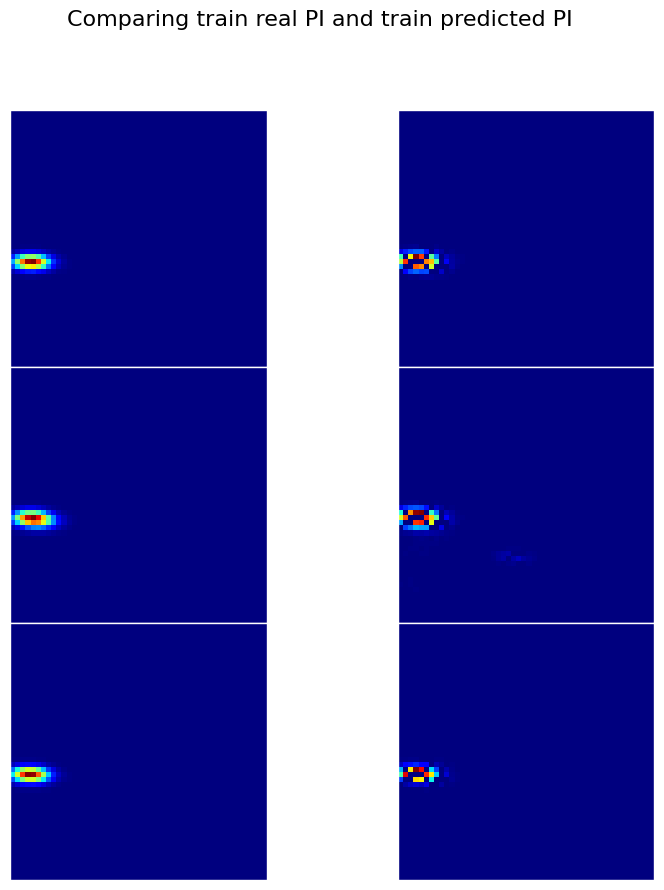

In [27]:
fig = plt.figure(figsize=(10, 10)) 
fig.suptitle(f"Comparing train real PI and train predicted PI", fontsize=16)
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(PI_train[200*i+1], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[i,1])
    ax.imshow(np.flip(np.reshape(train_PI_prediction[200*i+1], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])

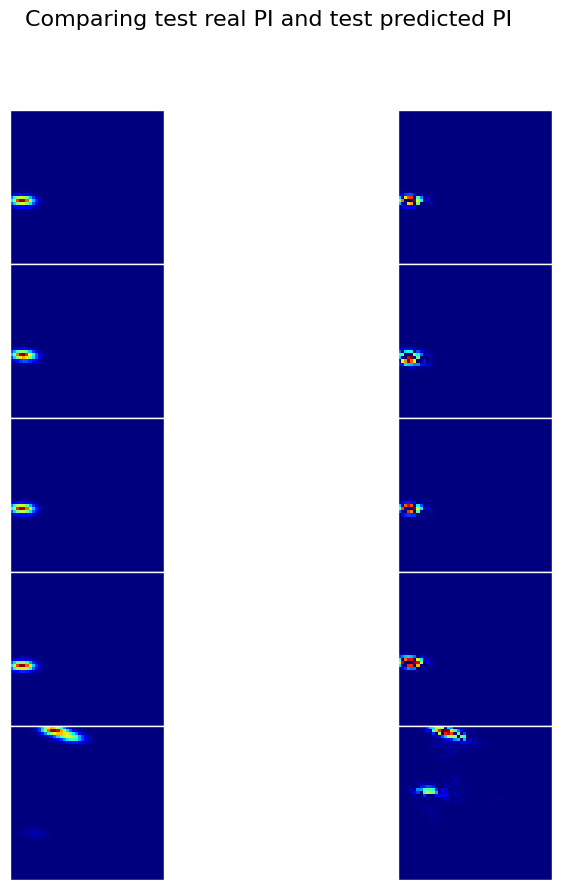

In [28]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle(f"Comparing test real PI and test predicted PI", fontsize=16)
gs = gridspec.GridSpec(5, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(5):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(clean_PI_test[100*i+i], [50,50]), 0), cmap='jet',)
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(gs[i,1])
    # ax.set_title(f"{labels[train_indexes[100*i][0]]} vs {labels[train_indexes[100*i][1]]}")
    ax.imshow(np.flip(np.reshape(clean_PI_prediction[100*i+i], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])

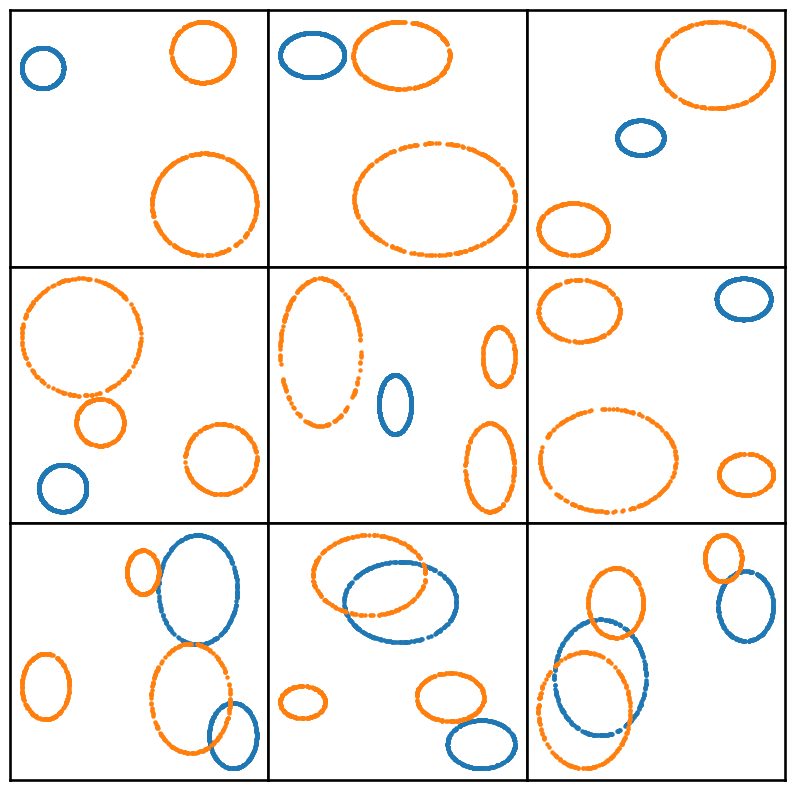

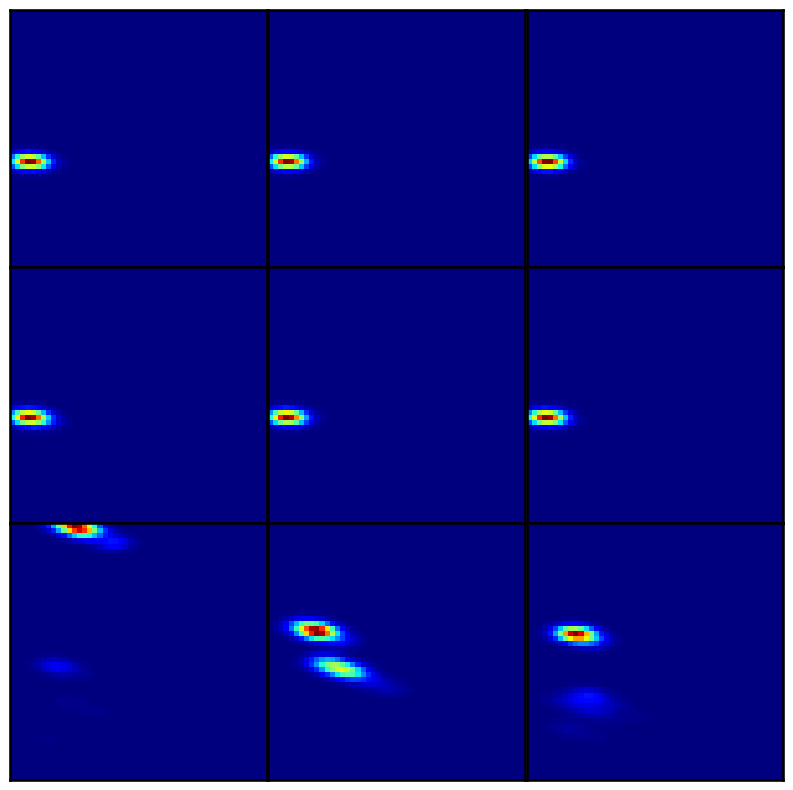

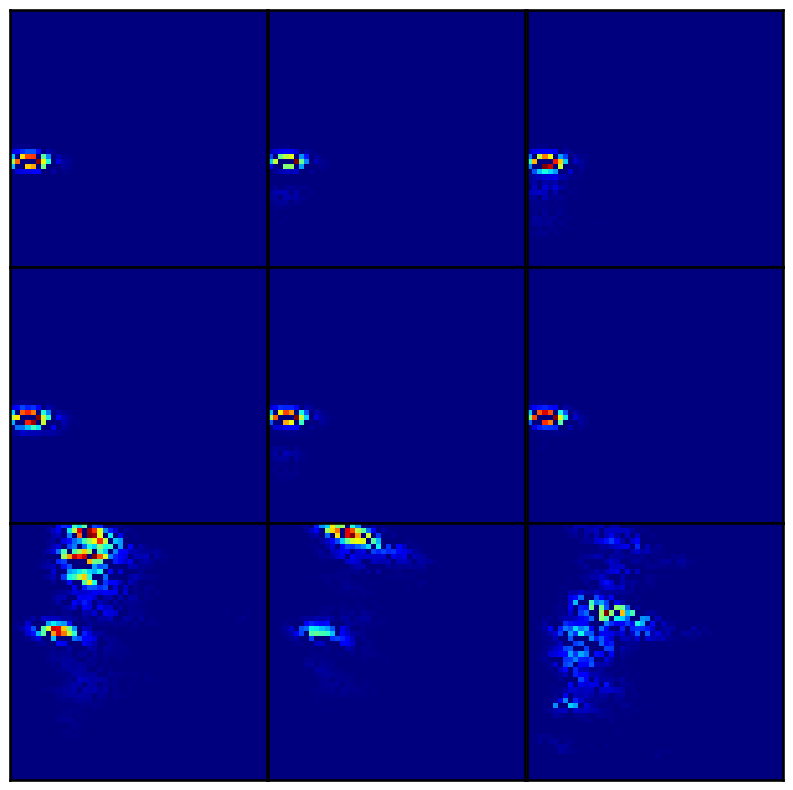

In [22]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(tf_data_test[200*i+j,:N_points,0], tf_data_test[200*i+j,:N_points,1], s=3)
        ax.scatter(tf_data_test[200*i+j,N_points:,0], tf_data_test[200*i+j,N_points:,1], s=3)
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_test[200*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_gudhi_pi.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_prediction[200*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_ripsnet_pi.png', bbox_inches='tight')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 517.87it/s]


Mean KL distance: 6.064837184352867


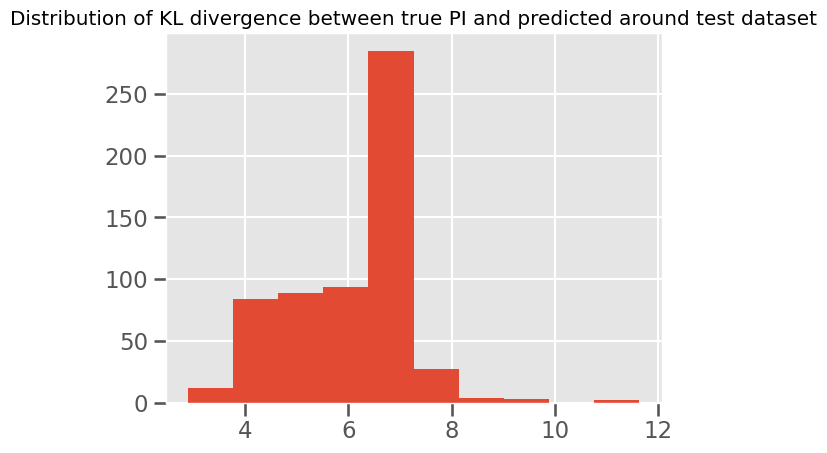

In [160]:
distances = measure_dist(clean_PI_prediction, clean_PI_test, method = "KL")
plt.hist(distances)
plt.title("Distribution of KL divergence between true PI and predicted around test dataset")
plt.show()

### Second approach: consider point clouds individually and as one big simultaneously. It means that we want to process clouds independently and together and, in the end, concatenate the results and pass them further to the NN.

In [46]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                            patience=50, verbose=0, mode='auto', baseline=None, 
                                            restore_best_weights=True)

optim = tf.keras.optimizers.Adamax(learning_rate=5e-4)
inputs_1 = tf.keras.Input(shape=(None,2), dtype ="float32", ragged=True)
inputs_2 = tf.keras.Input(shape=(None,2), dtype ="float32", ragged=True)
inputs_dist = tf.keras.Input(shape=(N_points, 300), dtype ="float32", ragged=False)

x = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_1)
x = DenseRagged(units=20, use_bias=True, activation='relu')(x)
x = DenseRagged(units=10, use_bias=True, activation='relu')(x)
x = PermopRagged()(x)

y = DenseRagged(units=30, use_bias=True, activation='relu')(inputs_2)
y = DenseRagged(units=20, use_bias=True, activation='relu')(y)
y = DenseRagged(units=10, use_bias=True, activation='relu')(y)
y = PermopRagged()(y)

x_y = keras.layers.Concatenate(axis=1)([inputs_1, inputs_2])
x_y = DenseRagged(units=30, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=20, use_bias=True, activation='relu')(x_y)
x_y = DenseRagged(units=10, use_bias=True, activation='relu')(x_y)
x_y= PermopRagged()(x_y)

d = DenseRagged(units=60, use_bias=True, activation='relu')(inputs_dist)
d = DenseRagged(units=40, use_bias=True, activation='relu')(d)
d = DenseRagged(units=30, use_bias=True, activation='relu')(d)
d = PermopRagged()(d)


z = keras.layers.Concatenate(axis=-1)([x, y, x_y, d])

# z = keras.layers.Concatenate(axis=-1)([x, y, x_y])

z = tf.keras.layers.Dense(150,  activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
# z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(200, activation='relu', kernel_regularizer=l2(1e-4), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(0.5)(z)
z = tf.keras.layers.Dense(400, activation='relu', kernel_regularizer=l2(1e-3), activity_regularizer=l2(1e-4))(z)
z = tf.keras.layers.Dropout(0.5)(z)
outputs = tf.keras.layers.Dense(PI_train.shape[1], activation='sigmoid')(z)
outputs = tf.keras.layers.Lambda(lambda x: tf.experimental.numpy.clip(x, 1e-8, None))(outputs) ## for preventiong calculating log(0)
outputs = tf.keras.layers.Lambda(lambda x: x / (tf.reduce_sum(x, axis=-1, keepdims=True) + 1e-7))(outputs)
model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2, inputs_dist], outputs=outputs)
# model_PI_second_type = tf.keras.Model(inputs=[inputs_1, inputs_2], outputs=outputs)
model_PI_second_type.compile(optimizer=optim, loss="kl_divergence")

In [31]:
tf_data_train_1 = tf.ragged.constant([
    [list(c) for c in list(data_train_concat[i, :N_points])] for i in range(len(data_train_concat))], ragged_rank=1)
tf_data_train_2 = tf.ragged.constant([
    [list(c) for c in list(data_train_concat[i, N_points:])] for i in range(len(data_train_concat))], ragged_rank=1)


tf_data_test_1 = tf.ragged.constant([
    [list(c) for c in list(data_test_concat[i, :N_points])] for i in range(len(data_test_concat))], ragged_rank=1)
tf_data_test_2 = tf.ragged.constant([
    [list(c) for c in list(data_test_concat[i, N_points:])] for i in range(len(data_test_concat))], ragged_rank=1)

### Let's calculate pairwise distances as new features 

In [32]:
pdist_train = np.zeros((data_train_concat.shape[0], N_points, 2*N_points))
for i in tqdm(range(data_train_concat.shape[0]), desc = "pdist for train dataset"):
    cloud_1 = data_train_concat[i, :N_points]
    cloud_2 = data_train_concat[i, N_points:]
    # NB !
    # Swapping point clouds for consistency with the paper
    cloud_1, cloud_2 = cloud_2, cloud_1
    
    d = sep_dist(cloud_1, cloud_2, pdist_device = "cuda")
    m = d[cloud_1.shape[0]:, :cloud_1.shape[0]].mean()
    d[:cloud_1.shape[0]][:cloud_1.shape[0]] = 0
    d[d < m*(1e-6)] = 0
    # pdist_train.append(d)
    pdist_train[i, :, :] = d[N_points:, :] ## because all upper numbers equal to zero

pdist_test = np.zeros((data_test_concat.shape[0], N_points, 2*N_points))
for i in tqdm(range(data_test_concat.shape[0]), desc = "pdist for test dataset"):
    cloud_1 = data_test_concat[i, :N_points]
    cloud_2 = data_test_concat[i, N_points:]
    # NB !
    # Swapping point clouds for consistency with the paper
    cloud_1, cloud_2 = cloud_2, cloud_1
    
    d = sep_dist(cloud_1, cloud_2, pdist_device = "cuda")
    m = d[cloud_1.shape[0]:, :cloud_1.shape[0]].mean()
    d[:cloud_1.shape[0]][:cloud_1.shape[0]] = 0
    d[d < m*(1e-6)] = 0
    pdist_test[i, :, :] = d[N_points:, :] ## because all upper numbers equal to zero

pdist for test dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 104.33it/s]


In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
pdist_train_reducted = np.array([pca.fit_transform(cloud) for cloud in pdist_train])
pdist_test_reducted = np.array([pca.fit_transform(cloud) for cloud in pdist_test])

In [47]:
history = model_PI_second_type.fit([tf_data_train_1, tf_data_train_2, pdist_train_reducted], PI_train, epochs=200, 
                       validation_data=([tf_data_test_1, tf_data_test_2, pdist_test_reducted], clean_PI_test), callbacks=[callback], verbose=1)

Epoch 1/200
75/75 [==============================] - 6s 53ms/step - loss: 4344.5215 - val_loss: 685.2332
Epoch 2/200
75/75 [==============================] - 3s 34ms/step - loss: 237.9428 - val_loss: 38.2103
Epoch 3/200
75/75 [==============================] - 3s 35ms/step - loss: 19.1784 - val_loss: 9.2704
Epoch 4/200
75/75 [==============================] - 3s 35ms/step - loss: 7.2652 - val_loss: 5.8301
Epoch 5/200
75/75 [==============================] - 3s 34ms/step - loss: 5.1802 - val_loss: 4.8741
Epoch 6/200
75/75 [==============================] - 3s 36ms/step - loss: 4.4905 - val_loss: 4.4307
Epoch 7/200
75/75 [==============================] - 3s 35ms/step - loss: 4.1350 - val_loss: 4.1273
Epoch 8/200
75/75 [==============================] - 2s 33ms/step - loss: 3.8518 - val_loss: 3.8256
Epoch 9/200
75/75 [==============================] - 2s 33ms/step - loss: 3.6138 - val_loss: 3.5753
Epoch 10/200
75/75 [==============================] - 3s 36ms/step - loss: 3.4147 - val_los

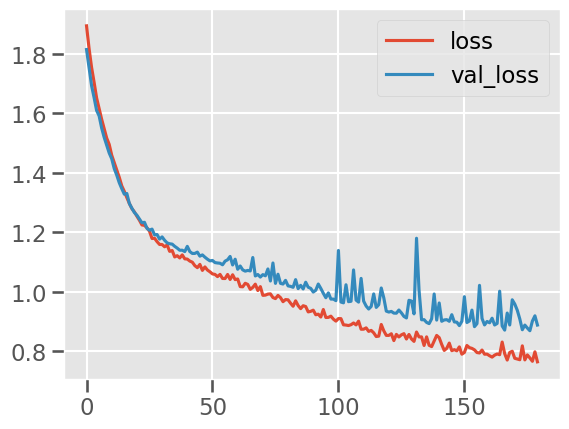

In [48]:
plt.plot(np.array(history.history["loss"][20:]))
plt.plot(np.array(history.history["val_loss"][20:]))
plt.legend(["loss", "val_loss"])
plt.show()

In [164]:
train_PI_prediction_second_type = model_PI_second_type.predict([tf_data_train_1, tf_data_train_2, pdist_train_reducted])
clean_PI_prediction_second_type = model_PI_second_type.predict([tf_data_test_1, tf_data_test_2, pdist_test_reducted])

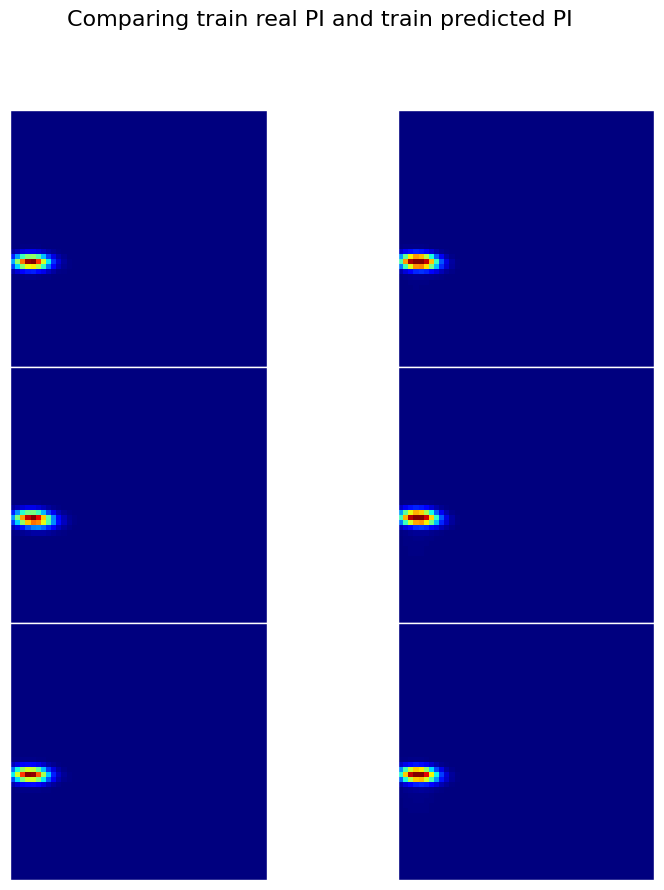

In [165]:
fig = plt.figure(figsize=(10, 10)) 
fig.suptitle(f"Comparing train real PI and train predicted PI", fontsize=16)
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(PI_train[200*i+1], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(gs[i,1])
    ax.imshow(np.flip(np.reshape(train_PI_prediction_second_type[200*i+1], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])

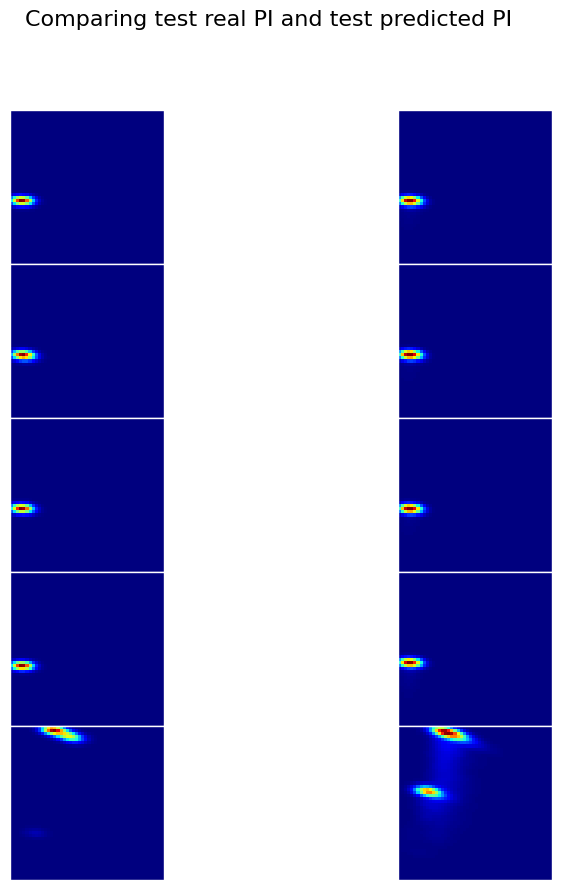

In [51]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle(f"Comparing test real PI and test predicted PI", fontsize=16)
gs = gridspec.GridSpec(5, 2, width_ratios=[1,1], wspace=0.0, hspace=0.0)
for i in range(5):
    ax = plt.subplot(gs[i,0])
    ax.imshow(np.flip(np.reshape(clean_PI_test[100*i+i], [50,50]), 0), cmap='jet',)
    plt.xticks([])
    plt.yticks([])

    ax = plt.subplot(gs[i,1])
    # ax.set_title(f"{labels[train_indexes[100*i][0]]} vs {labels[train_indexes[100*i][1]]}")
    ax.imshow(np.flip(np.reshape(clean_PI_prediction_second_type[100*i+i], [50,50]), 0), cmap='jet')
    plt.xticks([])
    plt.yticks([])

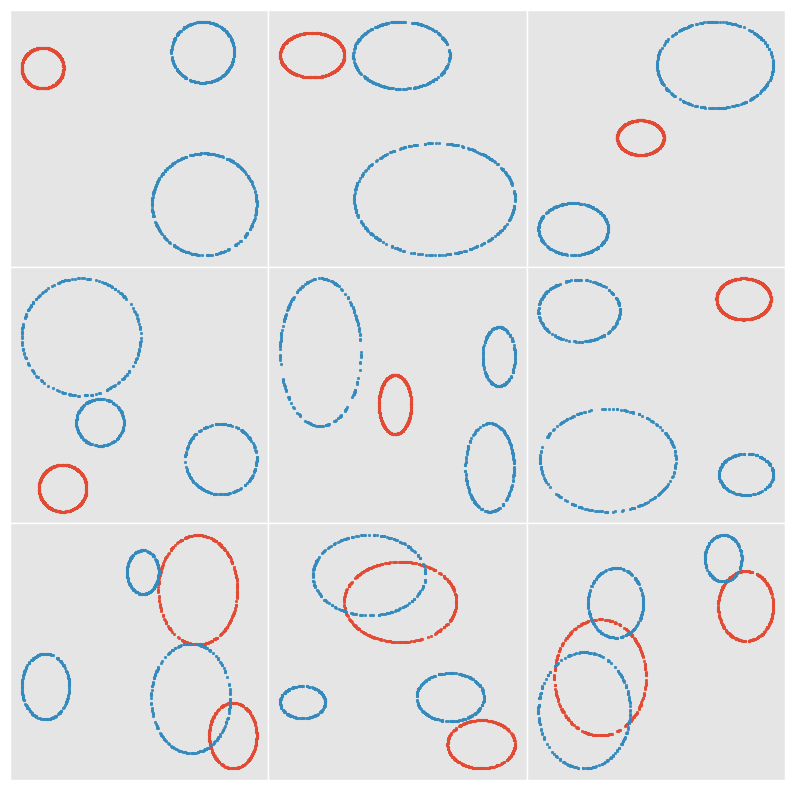

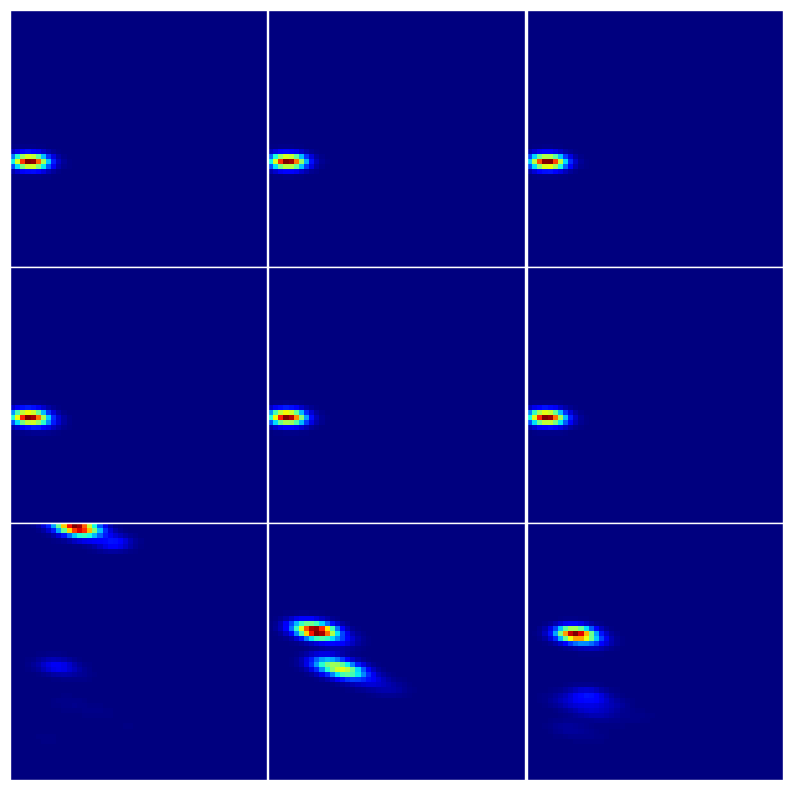

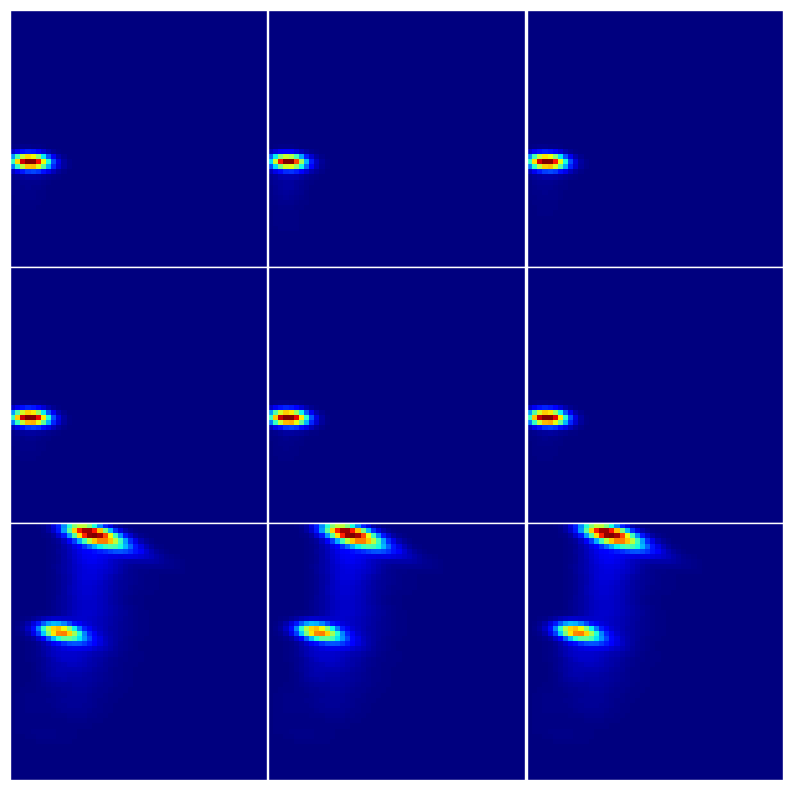

In [166]:
fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.scatter(tf_data_test[200*i+j,:N_points,0], tf_data_test[200*i+j,:N_points,1], s=3)
        ax.scatter(tf_data_test[200*i+j,N_points:,0], tf_data_test[200*i+j,N_points:,1], s=3)
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_gudhi_pc.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_test[200*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_gudhi_pi.png', bbox_inches='tight')

fig = plt.figure(figsize=(10, 10)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1,1,1], wspace=0.0, hspace=0.0)
for i in range(3):
    for j in range(3):
        ax = plt.subplot(gs[i,j])
        ax.imshow(np.flip(np.reshape(clean_PI_prediction_second_type[200*i+j], [50,50]), 0), cmap='jet')
        plt.xticks([])
        plt.yticks([])
# plt.savefig('clean_ripsnet_pi.png', bbox_inches='tight')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 536.86it/s]


Mean KL distance: 0.8362888016304639


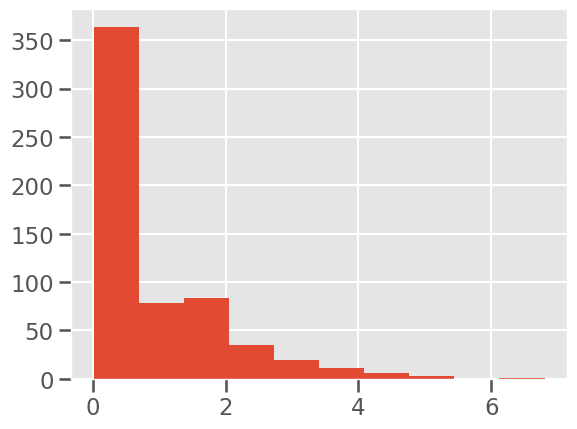

In [167]:
distances = measure_dist(clean_PI_prediction_second_type, clean_PI_test, method="KL")
plt.hist(distances)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 239.28it/s]


Mean KL distance: 0.2684886945067582
Loss computed by model V2: 0.2652190327644348
Loss computed by model V2 reverse: 0.19754572212696075
Loss computed by model V1: 5.146731853485107


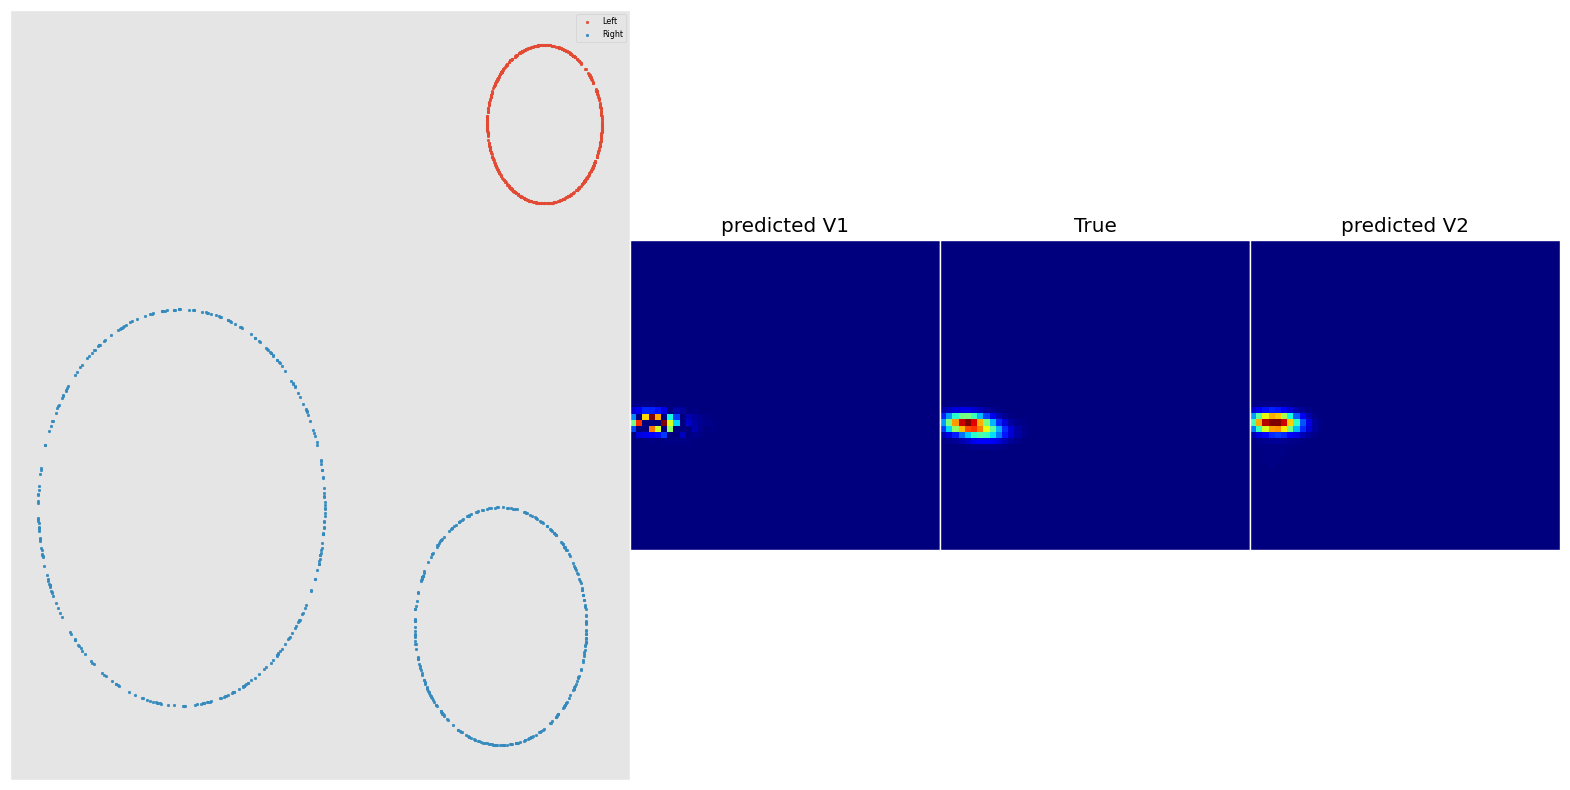

In [221]:
i_1 = 40
fig = plt.figure(figsize=(20, 10)) 
gs = gridspec.GridSpec(1, 4, width_ratios=[2,1,1,1], wspace=0.0, hspace=0.0)


ax = plt.subplot(gs[0])
ax.scatter(tf_data_test[i_1,:N_points,0], tf_data_test[i_1,:N_points,1], s=3,label = "Left")
ax.scatter(tf_data_test[i_1,N_points:,0], tf_data_test[i_1,N_points:,1], s=3,label = "Right")
plt.xticks([])
plt.yticks([])
plt.legend(fontsize = "xx-small")

ax = plt.subplot(gs[1])
ax.imshow(np.flip(np.reshape(clean_PI_prediction[i_1], [50,50]), 0), cmap='jet')
plt.xticks([])
plt.yticks([])
plt.title("predicted V1")

ax = plt.subplot(gs[2])
ax.imshow(np.flip(np.reshape(clean_PI_test[i_1], [50,50]), 0), cmap='jet')
plt.xticks([])
plt.yticks([])
plt.title("True")

ax = plt.subplot(gs[3])
ax.imshow(np.flip(np.reshape(clean_PI_prediction_second_type[i_1], [50,50]), 0), cmap='jet')
plt.xticks([])
plt.yticks([])
plt.title("predicted V2")

P = tf.convert_to_tensor([np.flip(np.reshape(clean_PI_test[i_1], [50,50]), 0).flatten()])
Q = tf.convert_to_tensor([np.flip(np.reshape(clean_PI_prediction_second_type[i_1], [50,50]), 0).flatten()])
R = tf.convert_to_tensor([np.flip(np.reshape(clean_PI_prediction[i_1], [50,50]), 0).flatten()])

measure_dist(Q, P, method="KL")

print(f"Loss computed by model V2: {model_PI_second_type.compiled_loss([P],[Q])}")
print(f"Loss computed by model V2 reverse: {model_PI_second_type.compiled_loss([Q],[P])}")
print(f"Loss computed by model V1: {model_PI_second_type.compiled_loss([P],[R])}")